# Bike Rebalances EDA
Citibike does not provide data regarding bike rebalances, however, a bike that starts from a station where it did not end its previous trip it likely was either rebalanced or taken out of service. We will assume the former is the case for this preliminary exercise and consider ways to make this more robust in the future.

Citibike article on rebalancing - [https://ride.citibikenyc.com/blog/rebalancing-the-citi-bike-system]

Future Work
- location based analysis was not faceted by time (year, month, DoW/weekend, holiday)
- interpretation of station/rebal rout significance not done due to lack of domain knowledge (basically we don't know why changes in time faceted rebalance work is significant but doable)

## Load Data

In [ ]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

pd.set_option("display.max_columns", None)
# sns.set(style="darkgrid")

%matplotlib inline

In [ ]:
print("loading...")
rebal = pd.read_parquet("../data/rebalance_parquet/all_rebalances_features.parquet")

# category conversions seemed like a good idea but really sucked when plotting
col_types = {
    # "bikeid": "category",
    "prevtrip_stoptime": "datetime64",
    "prevtrip_endstationid": "int16",
    "starttime": "datetime64",
    "startstationid": "int16",
    # "startstationname": "category",
    "startcapacity": "float16",
    # "startneighborhood": "category",
    # "startboro": "category",
    "startelevation_ft": "float16",
    # "prevtrip_endstationname": "category",
    "prevtrip_capacity": "float16",
    # "prevtrip_neighborhood": "category",
    # "prevtrip_boro": "category",
    "prevtrip_elevation_ft": "float16",
}

print("converting...")
rebal = rebal.astype(col_types)

rebal.head()

loading...
converting...


,bikeid,prevtrip_stoptime,prevtrip_endstationid,starttime,startstationid,rebal_time_hr,startstationname,startcapacity,startneighborhood,startboro,startelevation_ft,prevtrip_endstationname,prevtrip_capacity,prevtrip_neighborhood,prevtrip_boro,prevtrip_elevation_ft
0,14529,2014-01-15 21:59:03,358,2014-01-16 09:10:01,300,11.182778,Shevchenko Pl & E 7 St,NaN,East Village,Manhattan,39.34375,Christopher St & Greenwich St,50.0,West Village,Manhattan,18.109375
1,14529,2014-01-17 13:23:19,2023,2014-01-17 16:18:23,168,2.917778,W 18 St & 6 Ave,47.0,Manhattan Community Board 5,Manhattan,33.25000,E 55 St & Lexington Ave,NaN,Manhattan Community Board 5,Manhattan,43.750000
2,14529,2014-01-23 13:17:05,348,2014-01-27 12:52:52,438,95.596389,St Marks Pl & 1 Ave,47.0,East Village,Manhattan,25.68750,W Broadway & Spring St,46.0,Manhattan Community Board 2,Manhattan,16.390625
3,14529,2014-01-27 13:03:12,151,2014-02-07 11:01:18,488,261.968333,W 39 St & 9 Ave,44.0,Garment District,Manhattan,32.56250,Cleveland Pl & Spring St,33.0,Manhattan Community Board 2,Manhattan,33.375000
4,14529,2014-02-07 21:35:11,229,2014-03-21 08:42:17,173,995.118333,Broadway & W 49 St,NaN,Theater District,Manhattan,54.59375,Great Jones St,23.0,NoHo,Manhattan,41.562500


## Create Features

In [ ]:
# date/time features
rebal["rebal_dow"] = pd.DatetimeIndex(
    rebal["starttime"]
).dayofweek  # Monday = 0, Sunday = 6
rebal["rebal_dom"] = pd.DatetimeIndex(rebal["starttime"]).day
rebal["rebal_week"] = pd.DatetimeIndex(rebal["starttime"]).week
rebal["rebal_month"] = pd.DatetimeIndex(rebal["starttime"]).month
rebal["rebal_year"] = pd.DatetimeIndex(rebal["starttime"]).year

# elevation features
rebal["rebal_elev_change"] = rebal.startelevation_ft - rebal.prevtrip_elevation_ft
bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250]
rebal["startelevation_bin"] = pd.cut(rebal.startelevation_ft, bins=bins)
rebal["prevtrip_elevation_bin"] = pd.cut(rebal.prevtrip_elevation_ft, bins=bins)

# remove boro ville-marie
rebal = rebal.loc[rebal.prevtrip_boro != "Ville-Marie"]
rebal = rebal.loc[rebal.startboro != "Ville-Marie"]

rebal.head()

/tmp/ipykernel_288/823673034.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  rebal["rebal_week"] = pd.DatetimeIndex(rebal["starttime"]).week


,bikeid,prevtrip_stoptime,prevtrip_endstationid,starttime,startstationid,rebal_time_hr,startstationname,startcapacity,startneighborhood,startboro,startelevation_ft,prevtrip_endstationname,prevtrip_capacity,prevtrip_neighborhood,prevtrip_boro,prevtrip_elevation_ft,rebal_dow,rebal_dom,rebal_week,rebal_month,rebal_year,rebal_elev_change,startelevation_bin,prevtrip_elevation_bin
0,14529,2014-01-15 21:59:03,358,2014-01-16 09:10:01,300,11.182778,Shevchenko Pl & E 7 St,NaN,East Village,Manhattan,39.34375,Christopher St & Greenwich St,50.0,West Village,Manhattan,18.109375,3,16,3,1,2014,21.234375,"(25, 50]","(0, 25]"
1,14529,2014-01-17 13:23:19,2023,2014-01-17 16:18:23,168,2.917778,W 18 St & 6 Ave,47.0,Manhattan Community Board 5,Manhattan,33.25000,E 55 St & Lexington Ave,NaN,Manhattan Community Board 5,Manhattan,43.750000,4,17,3,1,2014,-10.500000,"(25, 50]","(25, 50]"
2,14529,2014-01-23 13:17:05,348,2014-01-27 12:52:52,438,95.596389,St Marks Pl & 1 Ave,47.0,East Village,Manhattan,25.68750,W Broadway & Spring St,46.0,Manhattan Community Board 2,Manhattan,16.390625,0,27,5,1,2014,9.296875,"(25, 50]","(0, 25]"
3,14529,2014-01-27 13:03:12,151,2014-02-07 11:01:18,488,261.968333,W 39 St & 9 Ave,44.0,Garment District,Manhattan,32.56250,Cleveland Pl & Spring St,33.0,Manhattan Community Board 2,Manhattan,33.375000,4,7,6,2,2014,-0.812500,"(25, 50]","(25, 50]"
4,14529,2014-02-07 21:35:11,229,2014-03-21 08:42:17,173,995.118333,Broadway & W 49 St,NaN,Theater District,Manhattan,54.59375,Great Jones St,23.0,NoHo,Manhattan,41.562500,4,21,12,3,2014,13.031250,"(50, 75]","(25, 50]"


In [ ]:
rebal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6609582 entries, 0 to 6610460
Data columns (total 24 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   bikeid                   int64         
 1   prevtrip_stoptime        datetime64[ns]
 2   prevtrip_endstationid    int16         
 3   starttime                datetime64[ns]
 4   startstationid           int16         
 5   rebal_time_hr            float64       
 6   startstationname         object        
 7   startcapacity            float16       
 8   startneighborhood        category      
 9   startboro                string        
 10  startelevation_ft        float16       
 11  prevtrip_endstationname  object        
 12  prevtrip_capacity        float16       
 13  prevtrip_neighborhood    category      
 14  prevtrip_boro            string        
 15  prevtrip_elevation_ft    float16       
 16  rebal_dow                int64         
 17  rebal_dom                in

## Rebalance Counts

### Unique Bikes Rebalanced

In [ ]:
# 32145 unique bikes rebalanced in total
rebal.bikeid.nunique()

32136

<AxesSubplot:title={'center':'Unique Bikes Rebalanced Per Year'}, xlabel='rebal_year'>

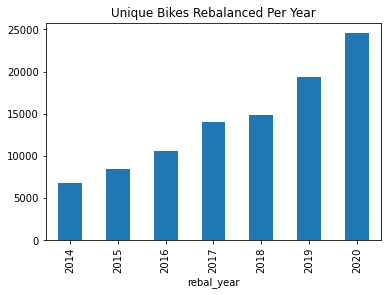

In [ ]:
# unique bikes rebalanced per year
rebal.groupby("rebal_year")["bikeid"].nunique().plot.bar(
    title="Unique Bikes Rebalanced Per Year"
)

### Total Bikes Rebalanced
- number of rebalances dropped sharply in 2018
  - number of unique bikes rebalanced close to 2017, but climbed sharply in 2019 and again in 2020
  - evidence of rebal rewards program?
- there is obvious seasonality in bike rebalances (months,days)
  -  likely follows trend in rides demand - to verify

/tmp/ipykernel_288/248452920.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_yticklabels(ylabels)


[Text(0, 0.0, '0.00 M'),
 Text(0, 200000.0, '0.20 M'),
 Text(0, 400000.0, '0.40 M'),
 Text(0, 600000.0, '0.60 M'),
 Text(0, 800000.0, '0.80 M'),
 Text(0, 1000000.0, '1.00 M'),
 Text(0, 1200000.0, '1.20 M'),
 Text(0, 1400000.0, '1.40 M'),
 Text(0, 1600000.0, '1.60 M')]

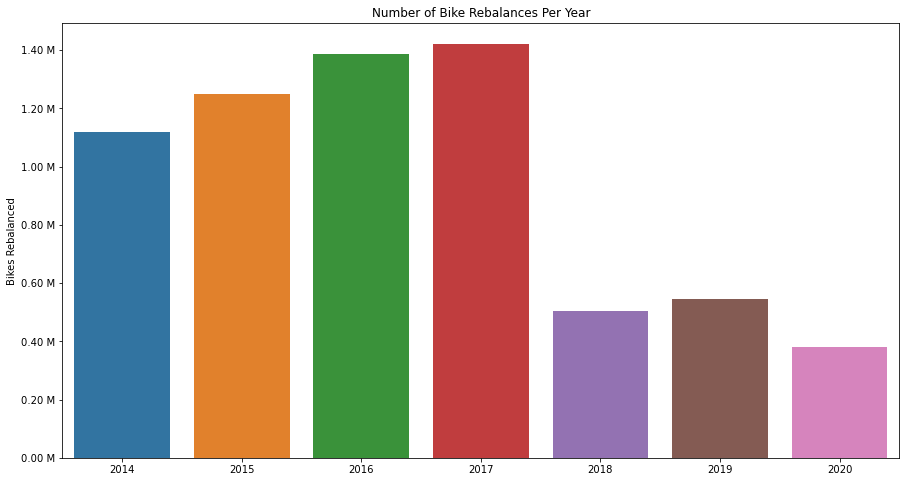

In [ ]:
# rebalances per year
g = rebal.groupby(["rebal_year"])[["bikeid"]].count().reset_index()
plt.figure(figsize=(15, 8))
x = sns.barplot(x=g.rebal_year, y=g.bikeid)
plt.ticklabel_format(style="plain", axis="y")
x.set(title="Number of Bike Rebalances Per Year", ylabel="Bikes Rebalanced", xlabel="")
ylabels = ["{:,.2f}".format(y) + " M" for y in x.get_yticks() / 1000000]
x.set_yticklabels(ylabels)

/tmp/ipykernel_288/179221656.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_yticklabels(ylabels)


[Text(0, 0.0, '0.00 M'),
 Text(0, 25000.0, '0.03 M'),
 Text(0, 50000.0, '0.05 M'),
 Text(0, 75000.0, '0.07 M'),
 Text(0, 100000.0, '0.10 M'),
 Text(0, 125000.0, '0.12 M'),
 Text(0, 150000.0, '0.15 M'),
 Text(0, 175000.0, '0.17 M'),
 Text(0, 200000.0, '0.20 M')]

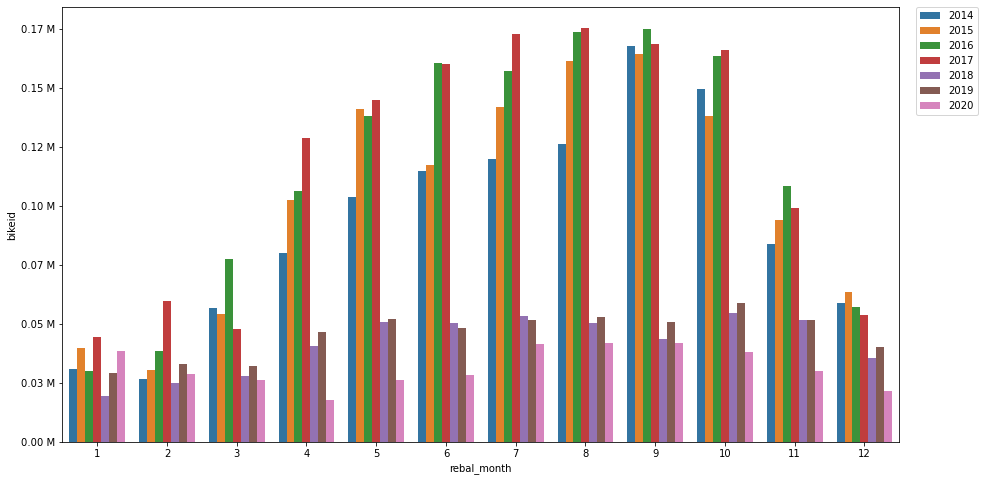

In [ ]:
# rebalances per month/year
g = rebal.groupby(["rebal_year", "rebal_month"])[["bikeid"]].count().reset_index()
plt.figure(figsize=(15, 8))
x = sns.barplot(x=g.rebal_month, y=g.bikeid, hue=g.rebal_year)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
ylabels = ["{:,.2f}".format(y) + " M" for y in x.get_yticks() / 1000000]
x.set_yticklabels(ylabels)

/tmp/ipykernel_288/4067675513.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_yticklabels(ylabels)


[Text(0, 0.0, '0.00 M'),
 Text(0, 25000.0, '0.03 M'),
 Text(0, 50000.0, '0.05 M'),
 Text(0, 75000.0, '0.07 M'),
 Text(0, 100000.0, '0.10 M'),
 Text(0, 125000.0, '0.12 M'),
 Text(0, 150000.0, '0.15 M'),
 Text(0, 175000.0, '0.17 M'),
 Text(0, 200000.0, '0.20 M')]

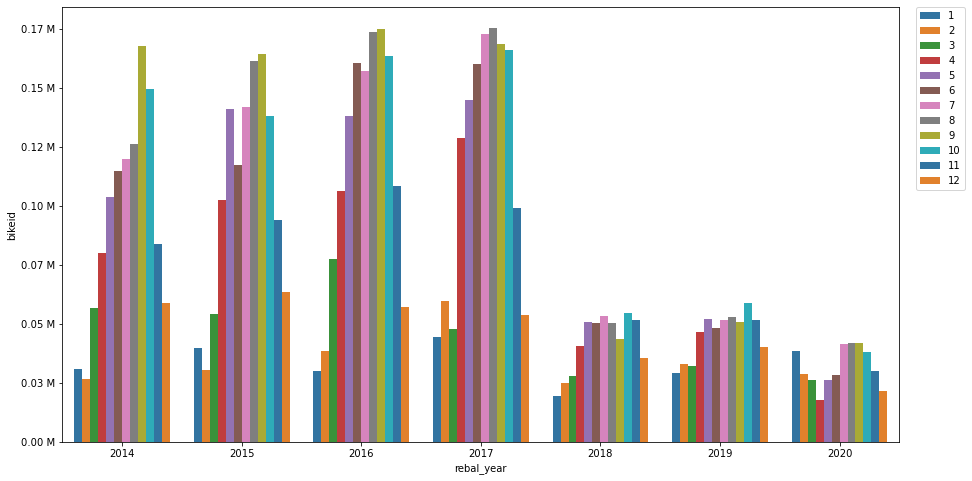

In [ ]:
# rebalances per month/year
g = rebal.groupby(["rebal_year", "rebal_month"])[["bikeid"]].count().reset_index()
plt.figure(figsize=(15, 8))
x = sns.barplot(x=g.rebal_year, y=g.bikeid, hue=g.rebal_month, palette="tab10")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
ylabels = ["{:,.2f}".format(y) + " M" for y in x.get_yticks() / 1000000]
x.set_yticklabels(ylabels)

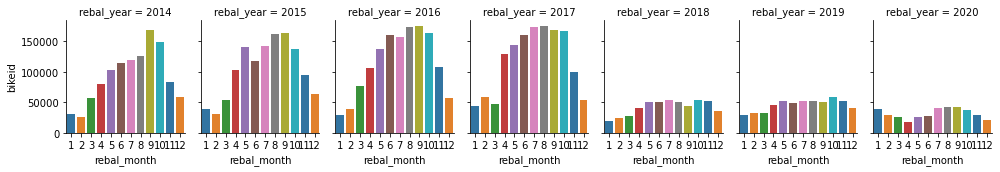

In [ ]:
# rebalances by month faceted by year
g = rebal.groupby(["rebal_year", "rebal_month"])[["bikeid"]].count().reset_index()
sns.catplot(
    x="rebal_month",
    y="bikeid",
    col="rebal_year",
    data=g,
    kind="bar",
    height=2.5,
    aspect=0.8,
    palette="tab10",
)

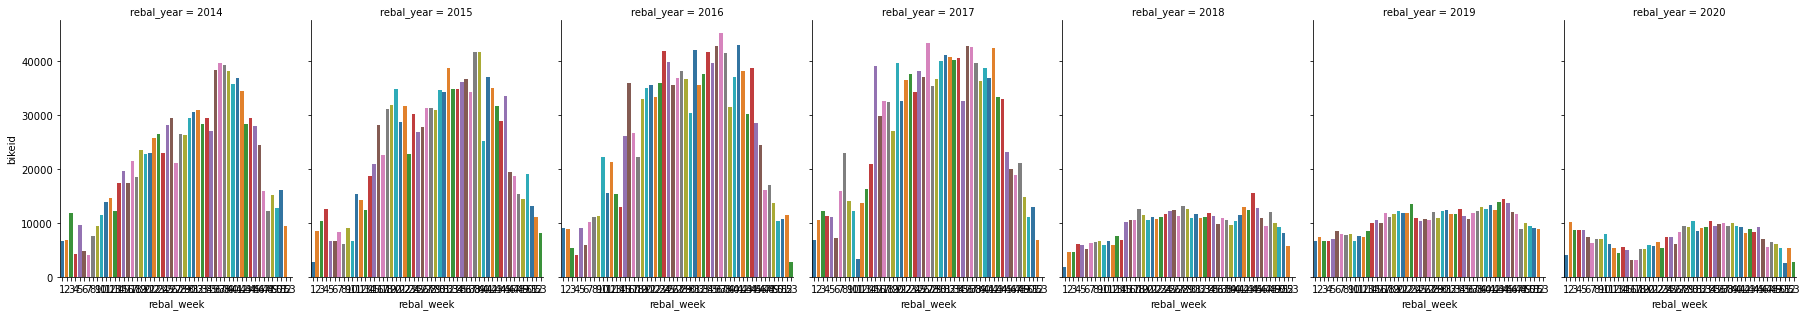

In [ ]:
# rebalances by week faceted by year
g = rebal.groupby(["rebal_year", "rebal_week"])[["bikeid"]].count().reset_index()
sns.catplot(
    x="rebal_week",
    y="bikeid",
    col="rebal_year",
    data=g,
    kind="bar",
    height=4.5,
    aspect=0.8,
    palette="tab10",
)

<AxesSubplot:xlabel='rebal_dow', ylabel='bikeid'>

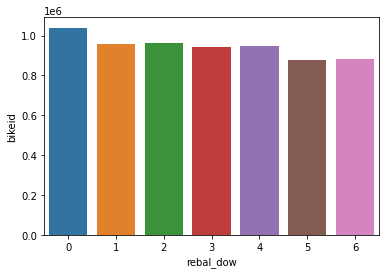

In [ ]:
# rebalances by DoW overall
g = rebal.groupby(["rebal_dow"])[["bikeid"]].count().reset_index()
sns.barplot(x="rebal_dow", y="bikeid", data=g)

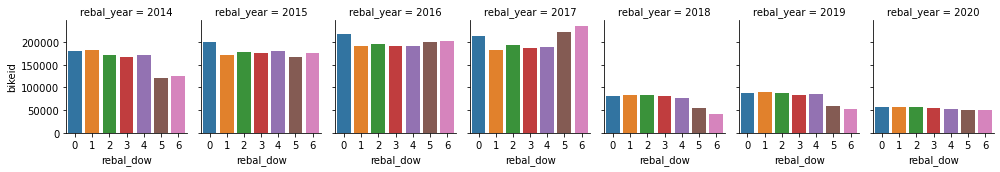

In [ ]:
# rebalances by DoW faceted by year
g = rebal.groupby(["rebal_year", "rebal_dow"])[["bikeid"]].count().reset_index()
sns.catplot(
    x="rebal_dow",
    y="bikeid",
    col="rebal_year",
    data=g,
    kind="bar",
    height=2.5,
    aspect=0.8,
)

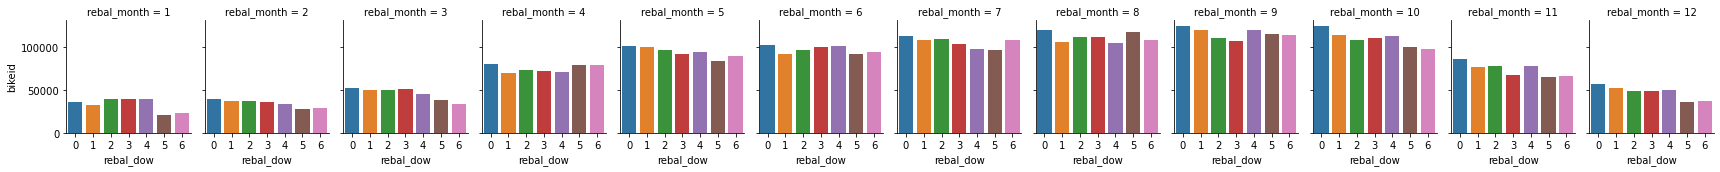

In [ ]:
# rebalances by DoW faceted by month
g = rebal.groupby(["rebal_month", "rebal_dow"])[["bikeid"]].count().reset_index()
sns.catplot(
    x="rebal_dow",
    y="bikeid",
    col="rebal_month",
    data=g,
    kind="bar",
    height=2.5,
    aspect=0.8,
)

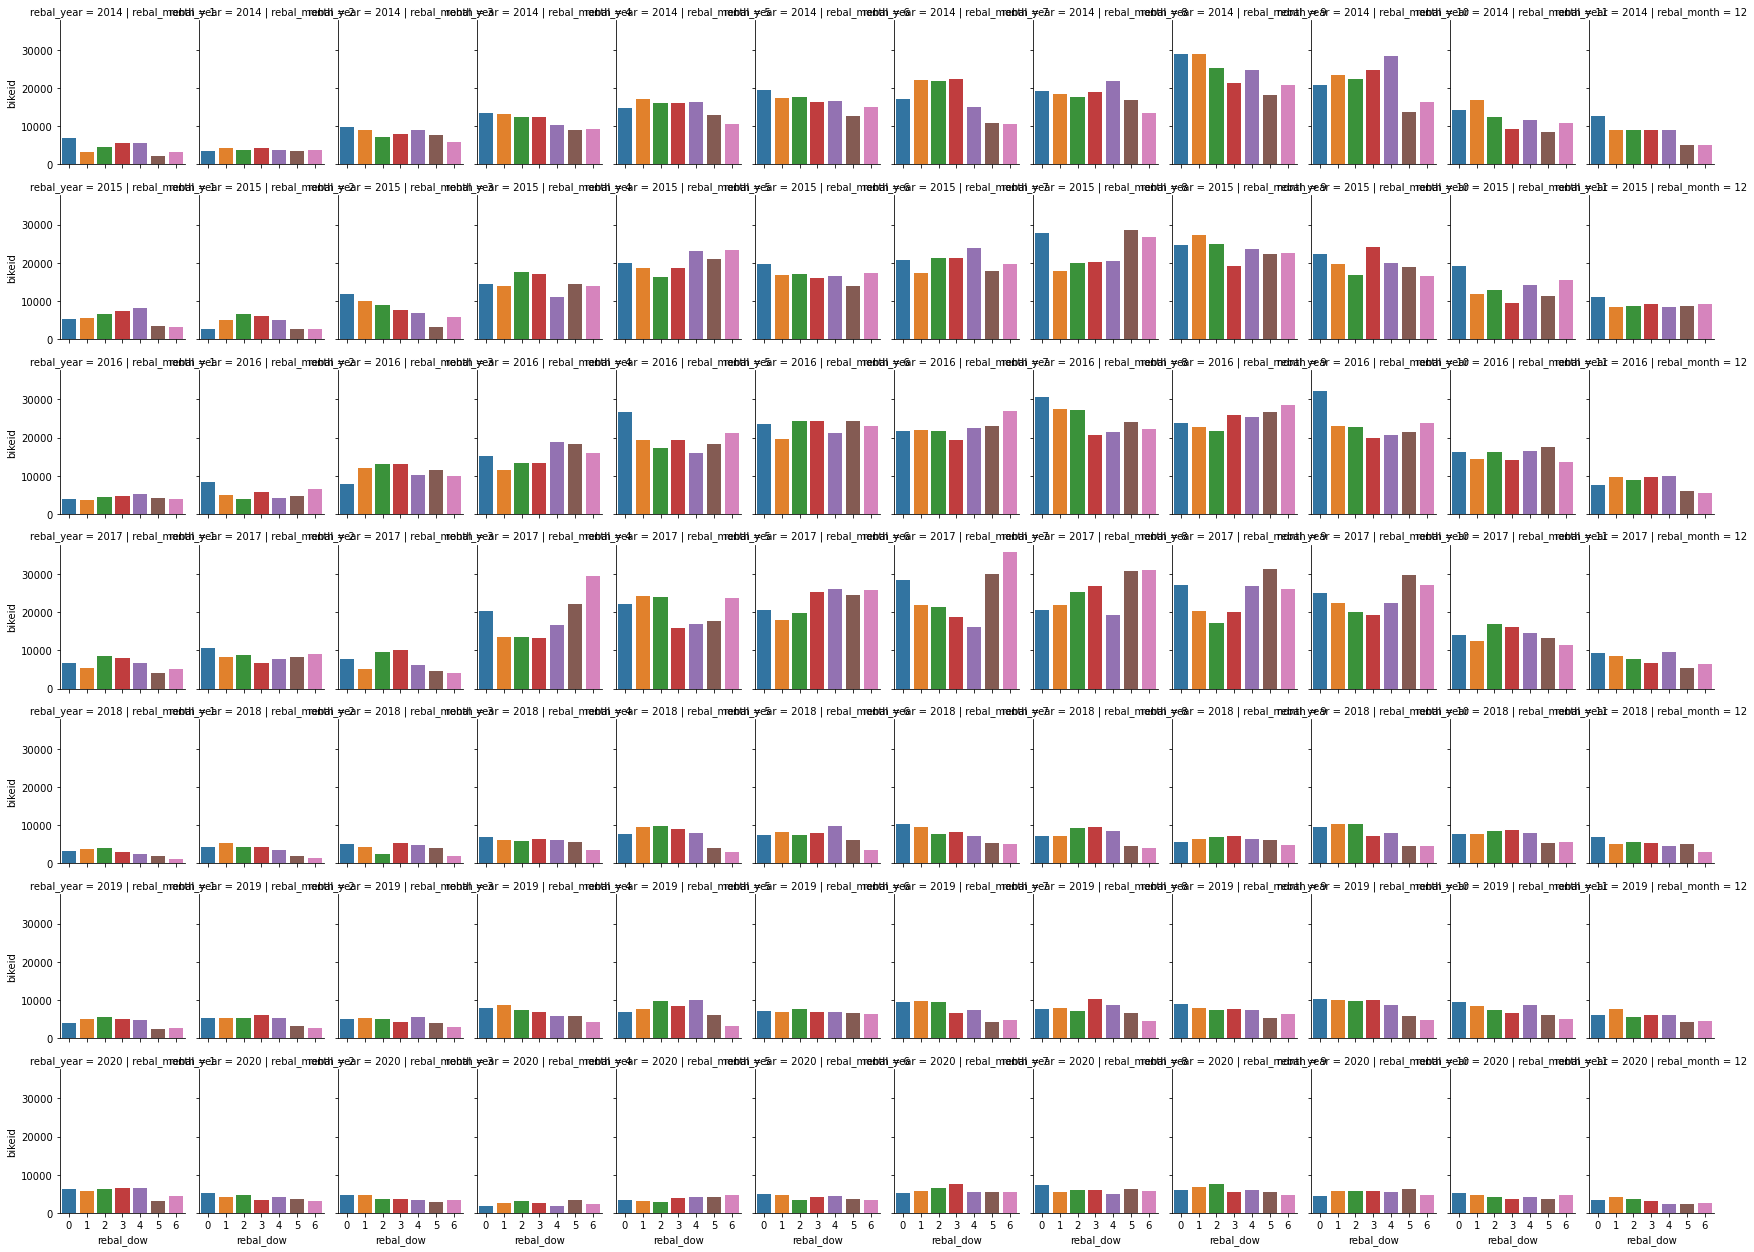

In [ ]:
# rebalances by DoW faceted by month and year
g = (
    rebal.groupby(["rebal_year", "rebal_month", "rebal_dow"])[["bikeid"]]
    .count()
    .reset_index()
)
sns.catplot(
    x="rebal_dow",
    y="bikeid",
    row="rebal_year",
    col="rebal_month",
    data=g,
    kind="bar",
    height=2.5,
    aspect=0.8,
)

## Elevation

### Change in elevation by each rebalance

<AxesSubplot:xlabel='rebal_elev_change', ylabel='Count'>

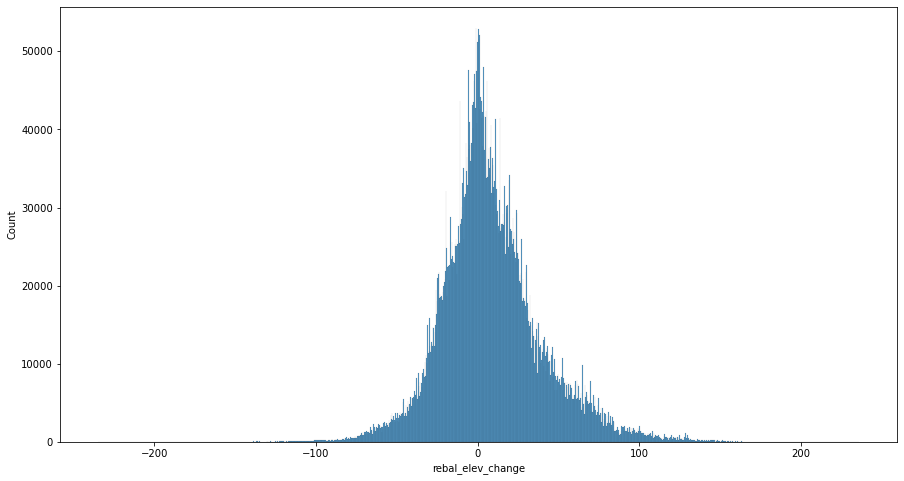

In [ ]:
# change in elevation for a given rebalance - overall
plt.figure(figsize=(15, 8))
sns.histplot(data=rebal, x="rebal_elev_change")

<AxesSubplot:xlabel='rebal_elev_change', ylabel='Count'>

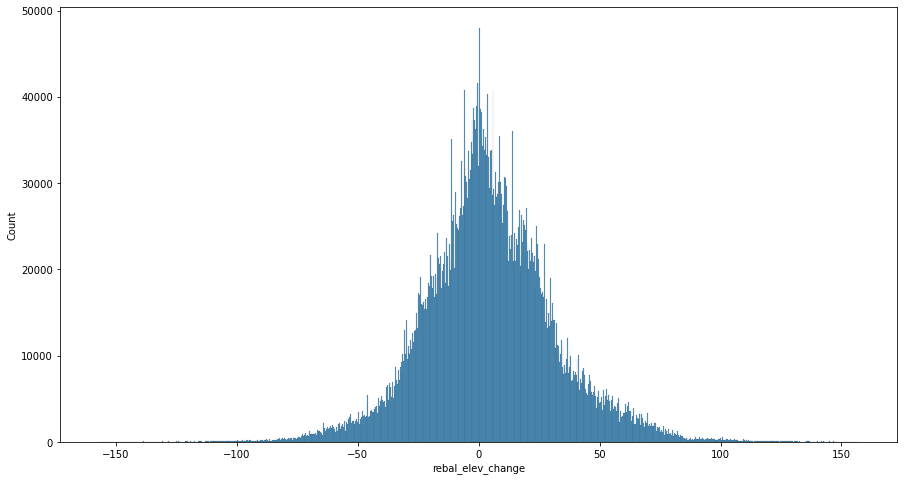

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(data=rebal.loc[rebal.rebal_year < 2018], x="rebal_elev_change")

<AxesSubplot:xlabel='rebal_elev_change', ylabel='Count'>

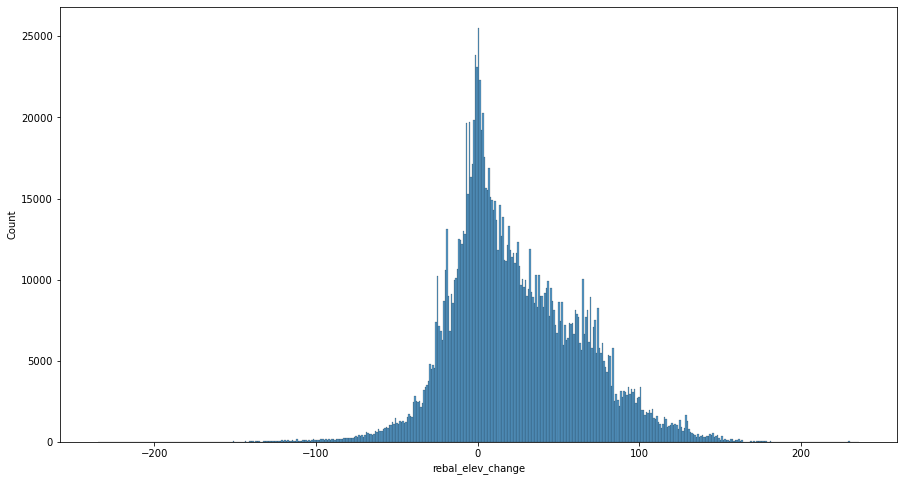

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(data=rebal.loc[rebal.rebal_year >= 2018], x="rebal_elev_change")

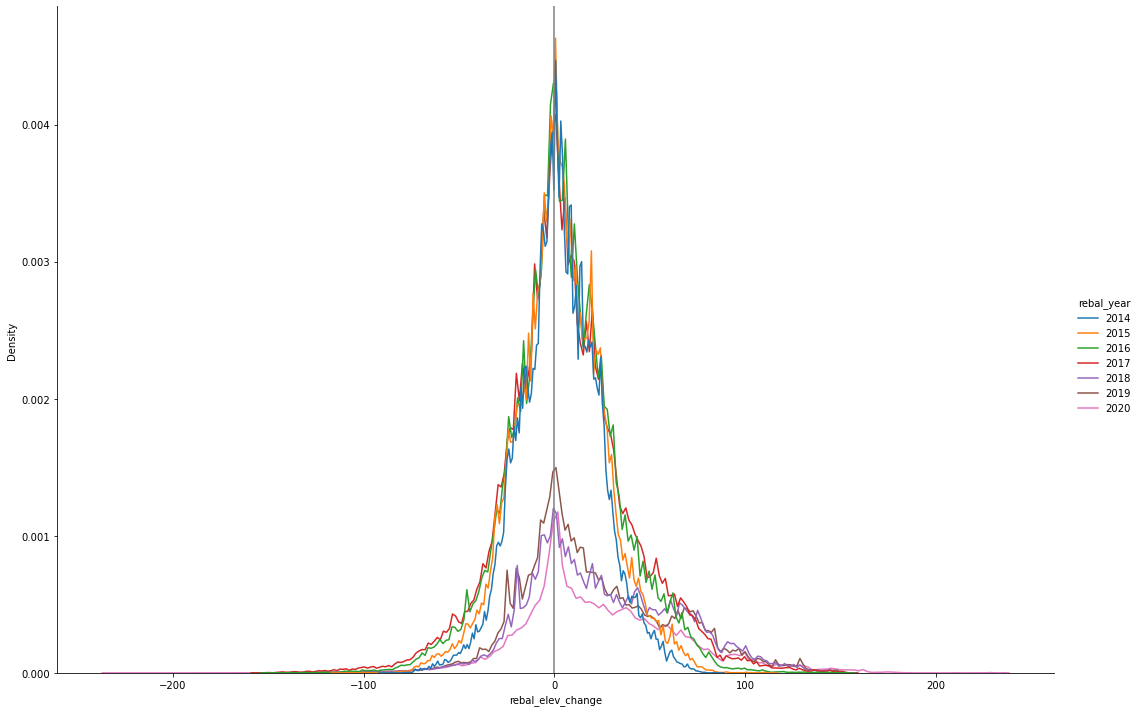

In [ ]:
sns.displot(
    data=rebal,
    x="rebal_elev_change",
    kind="kde",
    hue="rebal_year",
    bw_adjust=0.25,
    height=10,
    aspect=1.5,
    palette="tab10",
)
plt.axvline(0, c="gray")

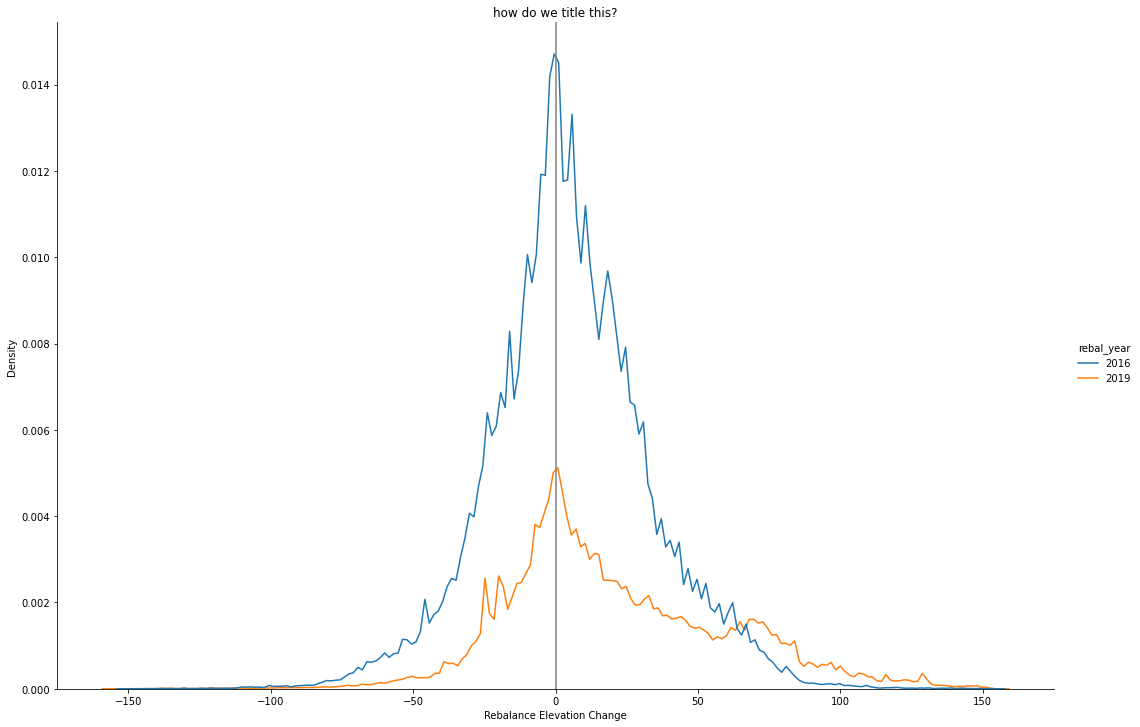

In [ ]:
x = sns.displot(
    data=rebal.loc[(rebal.rebal_year == 2016) | (rebal.rebal_year == 2019)],
    x="rebal_elev_change",
    kind="kde",
    hue="rebal_year",
    bw_adjust=0.25,
    height=10,
    aspect=1.5,
    palette="tab10",
)
plt.axvline(0, c="gray")
x.set(xlabel="Rebalance Elevation Change", title="how do we title this?")
# plt.xlabel='Rebalance Elevation Change'  #why doesn't this work?

### Rebalance by aggregate elevation bins

/tmp/ipykernel_288/550739753.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_yticklabels(ylabels)


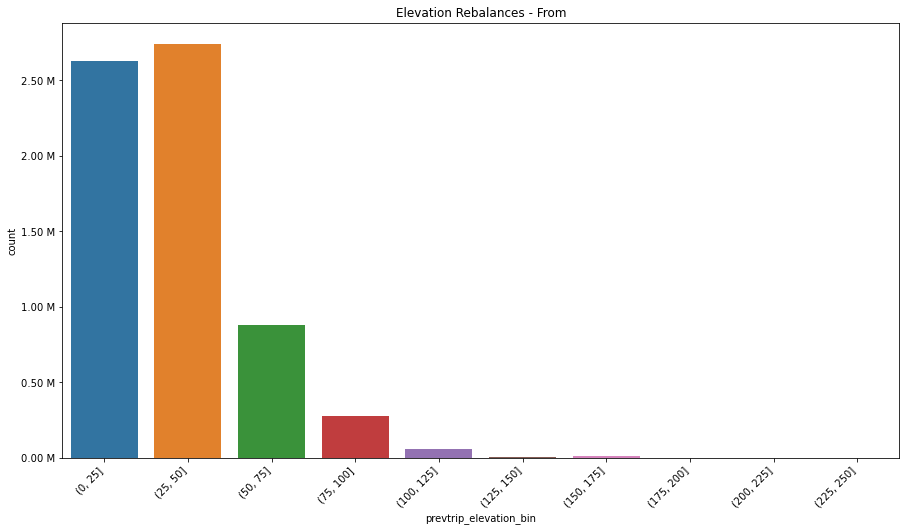

In [ ]:
# rebalances from elevation (binned)
plt.figure(figsize=(15, 8))
x = sns.countplot(x=rebal.prevtrip_elevation_bin)
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(title="Elevation Rebalances - From")
ylabels = ["{:,.2f}".format(y) + " M" for y in x.get_yticks() / 1000000]
x.set_yticklabels(ylabels)
plt.show()

/tmp/ipykernel_288/2582081637.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_yticklabels(ylabels)


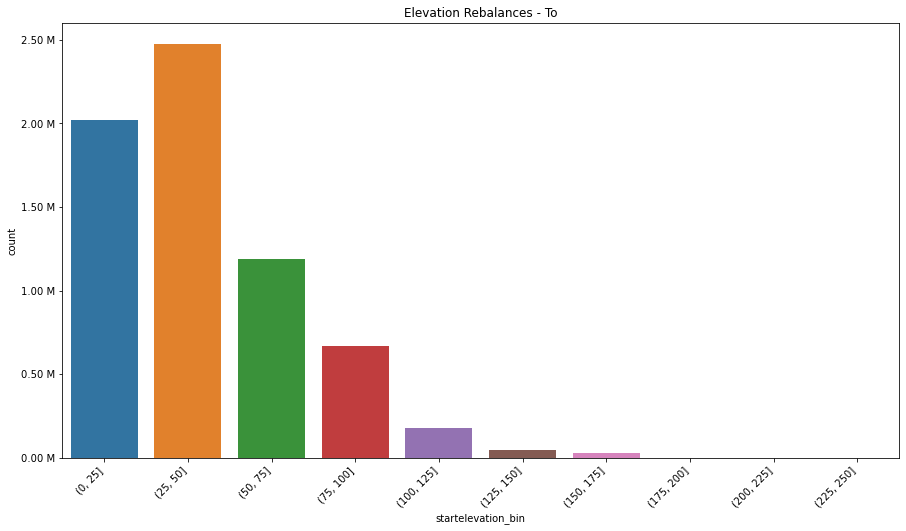

In [ ]:
# rebalances to elevation (binned)
plt.figure(figsize=(15, 8))
x = sns.countplot(x=rebal.startelevation_bin)
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(title="Elevation Rebalances - To")
ylabels = ["{:,.2f}".format(y) + " M" for y in x.get_yticks() / 1000000]
x.set_yticklabels(ylabels)
plt.show()

/tmp/ipykernel_288/3510646749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t["Flow"] = "To"
/tmp/ipykernel_288/3510646749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t.rename(columns={"startelevation_bin": "elevation"}, inplace=True)
/tmp/ipykernel_288/3510646749.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

[Text(0, 0.0, '0.00 M'),
 Text(0, 500000.0, '0.50 M'),
 Text(0, 1000000.0, '1.00 M'),
 Text(0, 1500000.0, '1.50 M'),
 Text(0, 2000000.0, '2.00 M'),
 Text(0, 2500000.0, '2.50 M'),
 Text(0, 3000000.0, '3.00 M')]

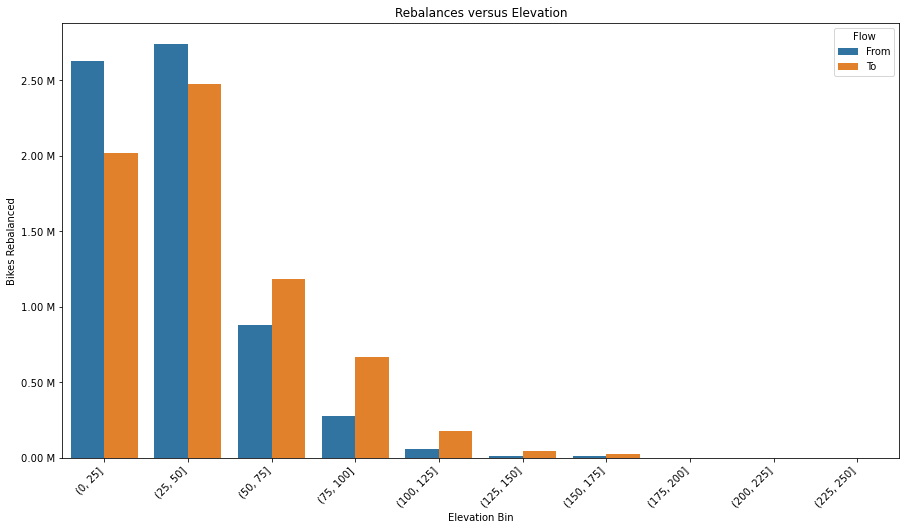

In [ ]:
# rebalances to & from (binned)
t = rebal[["startelevation_bin"]]
t["Flow"] = "To"
t.rename(columns={"startelevation_bin": "elevation"}, inplace=True)
f = rebal[["prevtrip_elevation_bin"]]
f["Flow"] = "From"
f.rename(columns={"prevtrip_elevation_bin": "elevation"}, inplace=True)
g = pd.concat([f, t], axis=0)
plt.figure(figsize=(15, 8))
x = sns.countplot(x=g.elevation, hue=g.Flow)
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(
    title="Rebalances versus Elevation",
    xlabel="Elevation Bin",
    ylabel="Bikes Rebalanced",
)
ylabels = ["{:,.2f}".format(y) + " M" for y in x.get_yticks() / 1000000]
x.set_yticklabels(ylabels)

## Capacity

In [ ]:
rebal.prevtrip_capacity.value_counts()

31.0    322597
39.0    302797
51.0    242787
66.0    215067
27.0    199485
         ...  
0.0       3535
75.0      2533
22.0      2060
17.0       866
16.0        46
Name: prevtrip_capacity, Length: 68, dtype: int64

In [ ]:
rebal.startcapacity.value_counts()

31.0    348717
39.0    341252
51.0    221977
66.0    204649
79.0    196545
         ...  
15.0      3844
26.0      3646
22.0      1726
17.0       744
16.0       121
Name: startcapacity, Length: 68, dtype: int64

<AxesSubplot:xlabel='startcapacity', ylabel='prevtrip_capacity'>

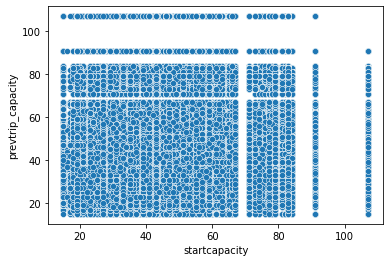

In [ ]:
sns.scatterplot(
    x=rebal.loc[rebal.startcapacity > 0].startcapacity,
    y=rebal.loc[rebal.prevtrip_capacity > 0].prevtrip_capacity,
)

In [ ]:
g = (
    rebal.groupby("startcapacity")["prevtrip_capacity"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "mean_prevtrip_capacity", "count": "count_rebal"})
)
g = g.loc[g.startcapacity > 0]
g

,startcapacity,mean_prevtrip_capacity,count_rebal
1,15.0,47.343750,3216
2,16.0,27.984375,52
3,17.0,34.250000,629
4,18.0,50.218750,73622
5,19.0,43.750000,67021
...,...,...,...
63,82.0,45.562500,10397
64,83.0,48.406250,25390
65,84.0,49.031250,9701
66,91.0,49.000000,29154


<AxesSubplot:xlabel='startcapacity', ylabel='mean_prevtrip_capacity'>

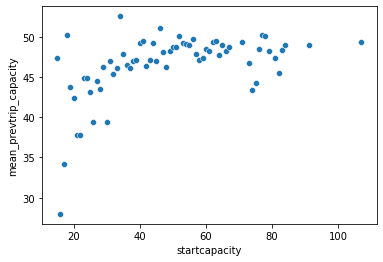

In [ ]:
# interesting...maybe?
sns.scatterplot(x=g.startcapacity, y=g.mean_prevtrip_capacity)

<AxesSubplot:xlabel='startcapacity', ylabel='count_rebal'>

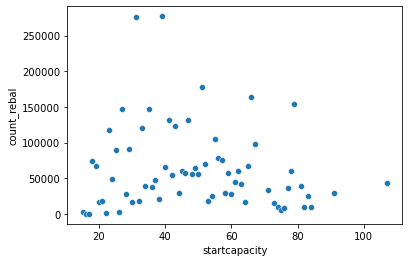

In [ ]:
# is this impactful?
sns.scatterplot(x=g.startcapacity, y=g.count_rebal)

## Station
No faceting performed, is possible if desired

### Indidual Station Analysis

(0.0, 96444.95812688391)

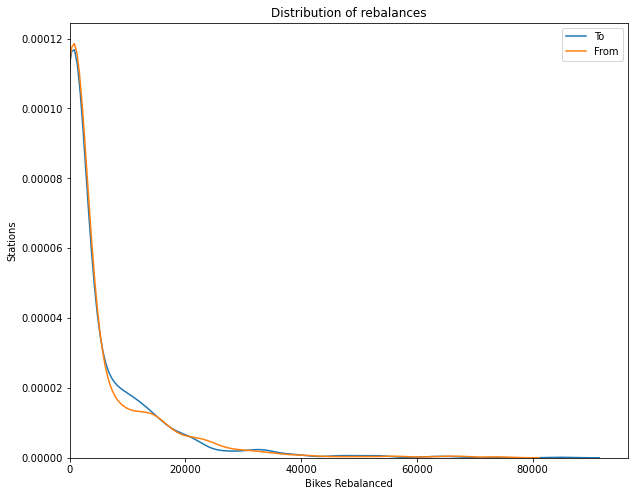

In [ ]:
# distribution of count of rebalances - combined
g1 = rebal.groupby("prevtrip_endstationname")[["bikeid"]].count()
g2 = rebal.groupby("startstationname")[["bikeid"]].count()


f, ax = plt.subplots(figsize=(10, 8))
ax = sns.kdeplot(x=g2.bikeid, label="To")
ax = sns.kdeplot(x=g1.bikeid, label="From")

ax.set(
    title="Distribution of rebalances",
    xlabel="Bikes Rebalanced",
    ylabel="Stations",
)
plt.legend()
plt.xlim(
    0,
)

(0.0, 85516.60047215964)

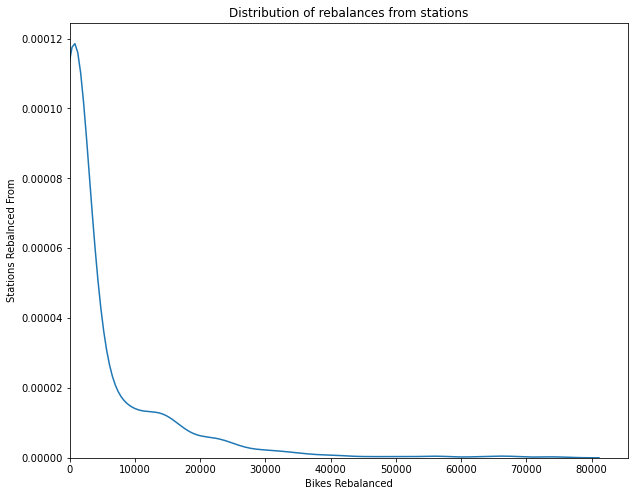

In [ ]:
# distribution of count of rebalances from
g = rebal.groupby("prevtrip_endstationname")[["bikeid"]].count()
plt.figure(figsize=(10, 8))
x = sns.kdeplot(x=g.bikeid)
x.set(
    title="Distribution of rebalances from stations",
    xlabel="Bikes Rebalanced",
    ylabel="Stations Rebalnced From",
)
plt.xlim(
    0,
)

(0.0, 96437.80611044221)

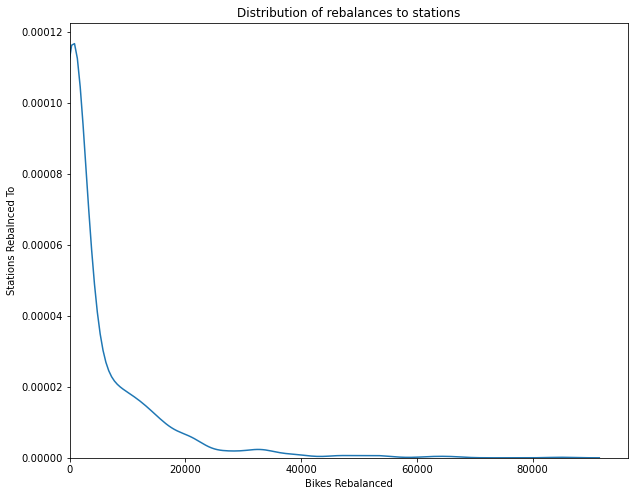

In [ ]:
# distribution of count of rebalances to
g = rebal.groupby("startstationname")[["bikeid"]].count()
plt.figure(figsize=(10, 8))
x = sns.kdeplot(x=g.bikeid)
x.set(
    title="Distribution of rebalances to stations",
    xlabel="Bikes Rebalanced",
    ylabel="Stations Rebalnced To",
)
plt.xlim(
    0,
)

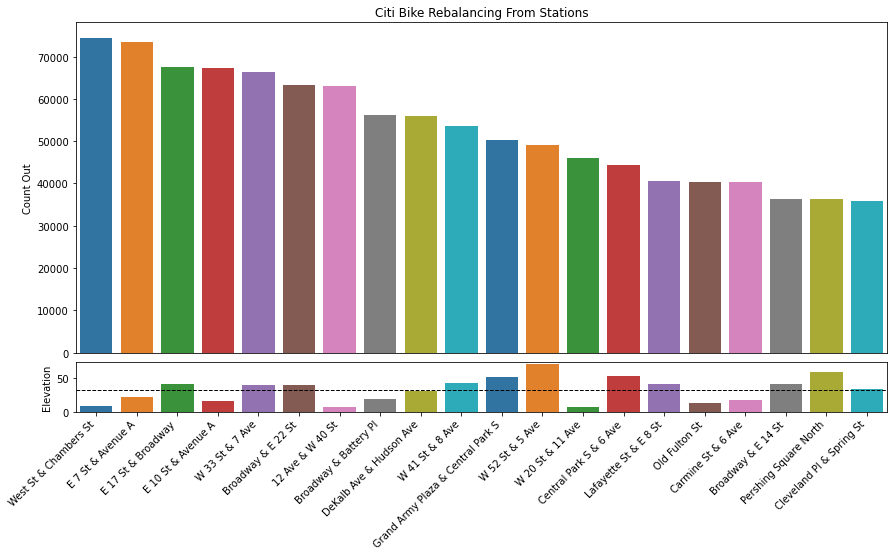

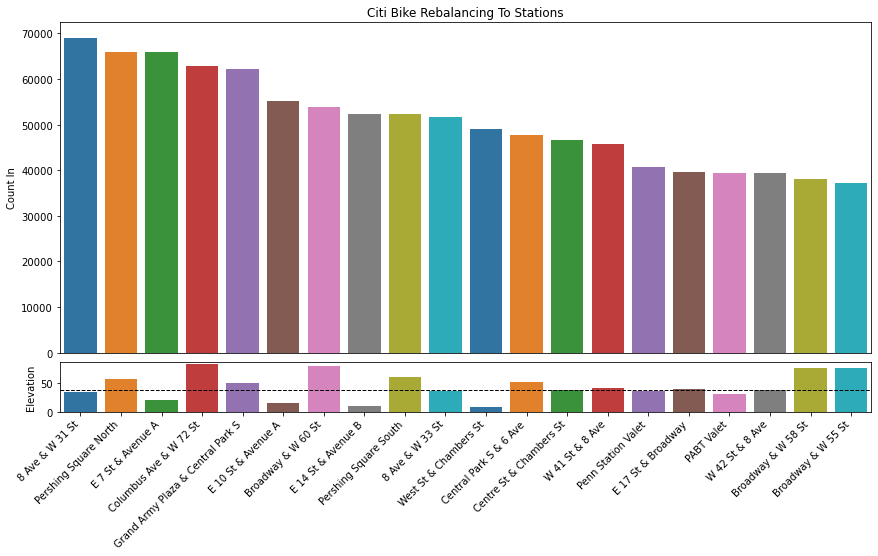

In [ ]:
# plot top20 rebalances
rebalout = (
    rebal[["prevtrip_endstationname", "prevtrip_elevation_ft"]]
    .value_counts()
    .reset_index()
    .rename(
        columns={
            "prevtrip_endstationname": "Station",
            "prevtrip_elevation_ft": "Elevation",
            0: "Count Out",
        }
    )[:20]
)

f, axs = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={"height_ratios": [1, 0.15]})
f.tight_layout()
f.subplots_adjust(hspace=0.05)
x = sns.barplot(x=rebalout.Station, y=rebalout["Count Out"], palette="tab10", ax=axs[0])
x.set(title="Citi Bike Rebalancing From Stations", xlabel="", xticks=[])
y = sns.barplot(x=rebalout.Station, y=rebalout.Elevation, palette="tab10", ax=axs[1])
y.set_xticklabels(y.get_xticklabels(), rotation=45, horizontalalignment="right")
y.set(xlabel="")
axs[1].axhline(rebal.prevtrip_elevation_ft.median(), c="black", lw=1, linestyle="--")
plt.show()


rebalin = (
    rebal[["startstationname", "startelevation_ft"]]
    .value_counts()
    .reset_index()
    .rename(
        columns={
            "startstationname": "Station",
            "startelevation_ft": "Elevation",
            0: "Count In",
        }
    )[:20]
)

f, axs = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={"height_ratios": [1, 0.15]})
f.tight_layout()
f.subplots_adjust(hspace=0.05)
x = sns.barplot(x=rebalin.Station, y=rebalin["Count In"], palette="tab10", ax=axs[0])
x.set(title="Citi Bike Rebalancing To Stations", xlabel="", xticks=[])
y = sns.barplot(x=rebalin.Station, y=rebalin.Elevation, palette="tab10", ax=axs[1])
y.set_xticklabels(y.get_xticklabels(), rotation=45, horizontalalignment="right")
y.set(xlabel="")
axs[1].axhline(rebal.startelevation_ft.median(), c="black", lw=1, linestyle="--")
plt.show()

### Pairwise Station Analysis

#### Create Rebalance Pair Table

In [ ]:
# group by pairs and count number per pair
rebpair = (
    rebal.groupby(["startstationname", "prevtrip_endstationname"])[["bikeid"]]
    .count()
    .reset_index()
    .sort_values(by="bikeid", ascending=False)
)
rebpair.rename(columns={"bikeid": "rebal_count"}, inplace=True)

# filter for only pairs that have been rebalanced more than ~10 times
rebpair = rebpair.loc[rebpair.rebal_count > 10]

# add elevation change column, round for easier plotting
rebpair = rebpair.merge(
    rebal[["startelevation_ft", "startstationname"]].drop_duplicates(
        subset="startstationname"
    ),
    how="left",
    on="startstationname",
).merge(
    rebal[["prevtrip_elevation_ft", "prevtrip_endstationname"]].drop_duplicates(
        subset="prevtrip_endstationname"
    ),
    how="left",
    on="prevtrip_endstationname",
)
rebpair["rebal_elev_change"] = rebpair.startelevation_ft - rebpair.prevtrip_elevation_ft
rebpair.drop(columns=["startelevation_ft", "prevtrip_elevation_ft"], inplace=True)
rebpair.rebal_elev_change = rebpair.rebal_elev_change.round()

# add capacity change column
rebpair = rebpair.merge(
    rebal[["startcapacity", "startstationname"]].drop_duplicates(
        subset="startstationname"
    ),
    how="left",
    on="startstationname",
).merge(
    rebal[["prevtrip_capacity", "prevtrip_endstationname"]].drop_duplicates(
        subset="prevtrip_endstationname"
    ),
    how="left",
    on="prevtrip_endstationname",
)
rebpair = rebpair.astype({"startcapacity": "float32", "prevtrip_capacity": "float32"})
rebpair["rebal_cap_change"] = rebpair.startcapacity - rebpair.prevtrip_capacity
rebpair.drop(columns=["startcapacity", "prevtrip_capacity"], inplace=True)
rebpair.rebal_elev_change = rebpair.rebal_elev_change.round()

# add id columns
rebpair = rebpair.merge(
    rebal[["startstationid", "startstationname"]].drop_duplicates(
        subset="startstationname"
    ),
    how="left",
    on="startstationname",
).merge(
    rebal[["prevtrip_endstationid", "prevtrip_endstationname"]].drop_duplicates(
        subset="prevtrip_endstationname"
    ),
    how="left",
    on="prevtrip_endstationname",
)
rebpair.rename(
    columns={
        "startstationid": "stationid_to",
        "prevtrip_endstationid": "stationid_from",
    },
    inplace=True,
)

# a very small number of rows contain elevations that are +/- inf, change to 0 and ignore
rebpair.loc[rebpair.rebal_elev_change < -300, "rebal_elev_change"] = 0
rebpair.loc[rebpair.rebal_elev_change > 300, "rebal_elev_change"] = 0

# create a single string for rebalance route
rebpair["rebal_route"] = (
    rebpair.prevtrip_endstationname.astype("str")
    + " to "
    + rebpair.startstationname.astype("str")
)

rebpair.head()

,startstationname,prevtrip_endstationname,rebal_count,rebal_elev_change,rebal_cap_change,stationid_to,stationid_from,rebal_route
0,E 14 St & Avenue B,E 7 St & Avenue A,14800,-11.0,0.0,511,432,E 7 St & Avenue A to E 14 St & Avenue B
1,Broadway & W 41 St,W 41 St & 8 Ave,10047,14.0,-32.0,465,477,W 41 St & 8 Ave to Broadway & W 41 St
2,E 7 St & Avenue A,E 14 St & Avenue B,7840,11.0,0.0,432,511,E 14 St & Avenue B to E 7 St & Avenue A
3,E 20 St & FDR Drive,E 7 St & Avenue A,7816,-17.0,NaN,487,432,E 7 St & Avenue A to E 20 St & FDR Drive
4,E 7 St & Avenue A,Cooper Square & E 7 St,6237,-20.0,NaN,432,3263,Cooper Square & E 7 St to E 7 St & Avenue A


In [ ]:
rebpair.shape

(105557, 8)

#### Rebpair Density and Distrobution

/home/jgoud/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='rebal_count', ylabel='rebal_elev_change'>

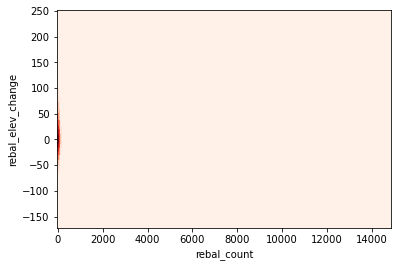

In [ ]:
sns.kdeplot(
    x=rebpair.rebal_count,
    y=rebpair.rebal_elev_change,
    shade=True,
    shade_lowest=True,
    cmap="Reds",
)

/home/jgoud/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


(0.0, 500.0)

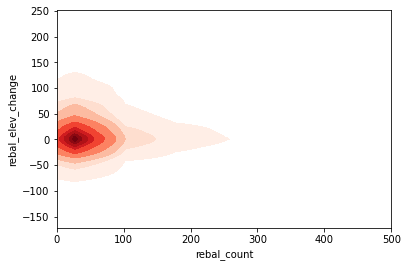

In [ ]:
sns.kdeplot(
    x=rebpair.rebal_count,
    y=rebpair.rebal_elev_change,
    shade=True,
    shade_lowest=False,
    cmap="Reds",
)
plt.xlim(0, 500)

/home/jgoud/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)
/home/jgoud/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='rebal_count', ylabel='rebal_elev_change'>

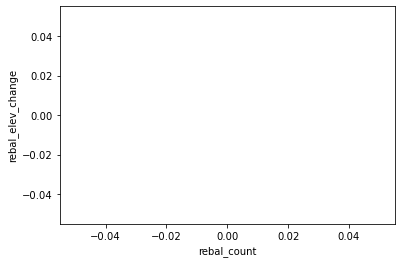

In [ ]:
# not enough data for high rebalances
sns.kdeplot(
    x=rebpair.loc[rebpair.rebal_count > 14000].rebal_count,
    y=rebpair.rebal_elev_change,
    shade=True,
    shade_lowest=True,
    cmap="Reds",
)

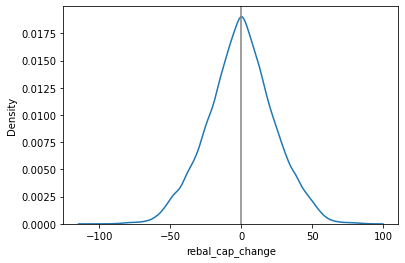

In [ ]:
# pairwise capacity change
sns.kdeplot(x=rebpair.rebal_cap_change)
plt.axvline(0, c="gray")

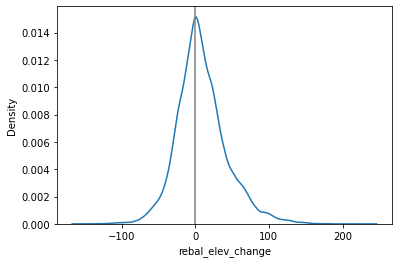

In [ ]:
# pairwise elevation change rebalances
sns.kdeplot(x=rebpair.rebal_elev_change)
plt.axvline(0, c="gray")

[Text(0.5, 1.0, 'Distribution of pairwise rebalances'),
 Text(0.5, 0, 'Bikes Rebalanced'),
 Text(0, 0.5, 'Station Pairs')]

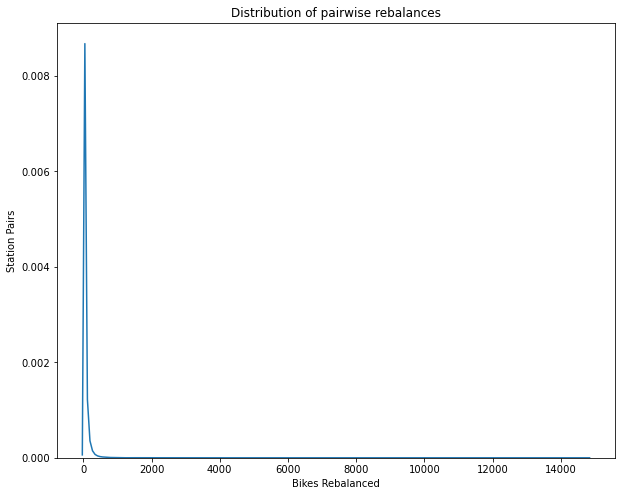

In [ ]:
# distribution of count of pairwise rebalances
plt.figure(figsize=(10, 8))
x = sns.kdeplot(x=rebpair.rebal_count)
x.set(
    title="Distribution of pairwise rebalances",
    xlabel="Bikes Rebalanced",
    ylabel="Station Pairs",
)

#### Most Frequent Rebalance Routes (one way flow)

[Text(0.5, 1.0, 'Most Frequent Rebalance Routes'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Number of Bikes Rebalanced')]

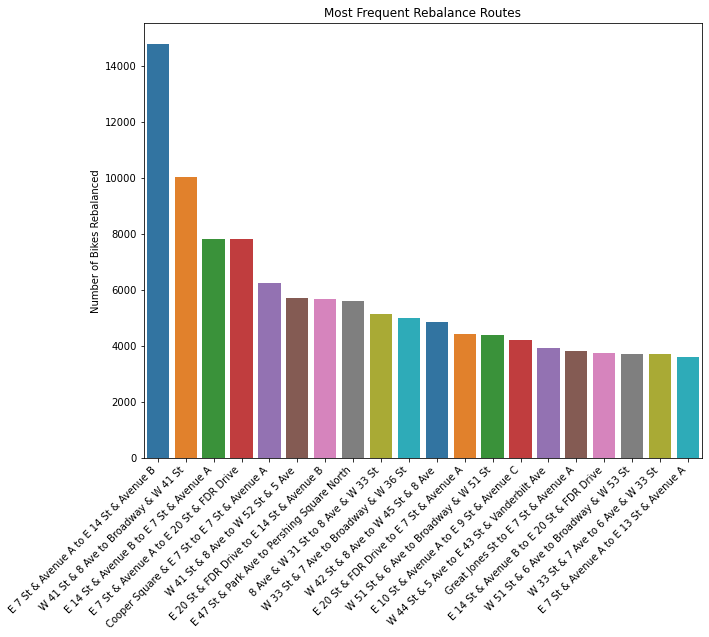

In [ ]:
# plot most frequent rebalance routes, ordered by count (top 20)
plt.figure(figsize=(10, 8))
x = sns.barplot(y=rebpair.rebal_count, x=rebpair.rebal_route[:20], palette="tab10")
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(
    title="Most Frequent Rebalance Routes",
    xlabel="",
    ylabel="Number of Bikes Rebalanced",
)

(0.0, 1.0, 0.0, 1.0)

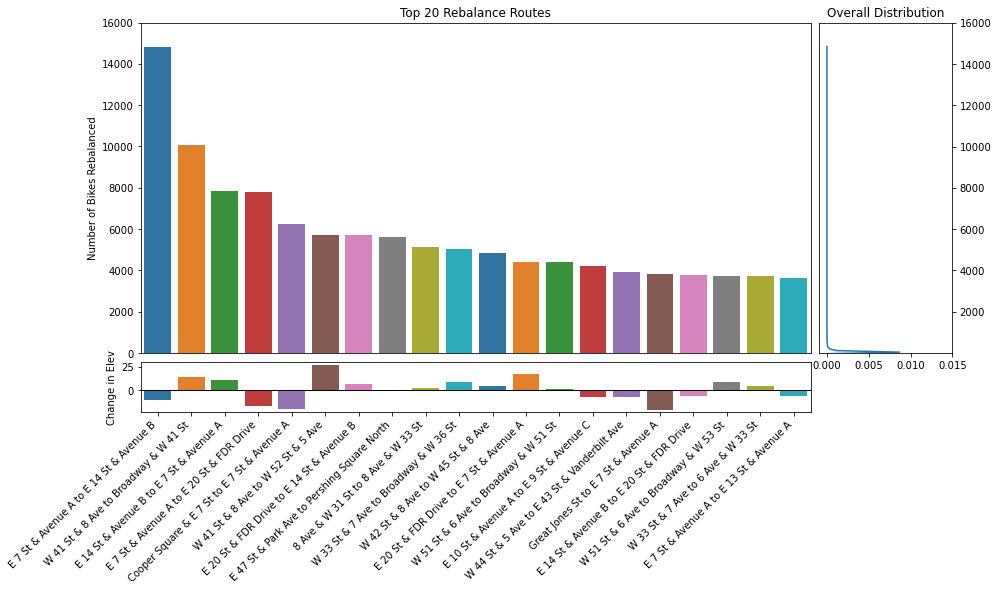

In [ ]:
# combine above with elevation data and rebal route distribution
f, axs = plt.subplots(
    2,
    2,
    figsize=(12, 6),
    gridspec_kw={"height_ratios": [1, 0.15], "width_ratios": [1, 0.2]},
)
f.tight_layout()
f.subplots_adjust(wspace=0.02, hspace=0.05)

# plot rebal routes
y = sns.barplot(
    y=rebpair.rebal_count, x=rebpair.rebal_route[:20], ax=axs[0, 0], palette="tab10"
)
y.set(xticklabels=[], xticks=[], ylim=(0, 16000))
y.set(
    title="Top 20 Rebalance Routes",
    xlabel="",
    ylabel="Number of Bikes Rebalanced",
)

# plot rebal elevaton changes
x = sns.barplot(
    y=rebpair.rebal_elev_change,
    x=rebpair.rebal_route[:20],
    ax=axs[1, 0],
    palette="tab10",
)
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(
    xlabel="",
    ylabel="Change in Elev",
)
axs[1, 0].axhline(0, c="black", lw=1)

# plot rebal distribution
z = sns.kdeplot(y=rebpair.rebal_count, ax=axs[0, 1], log_scale=[False, False])
z.set(
    ylim=(9, 16000),
    xlim=(-0.001, 0.015),
    title="Overall Distribution",
    xlabel="",
    ylabel="",
)
axs[0, 1].yaxis.tick_right()


# hide last axis
axs[-1, -1].axis("off")

/tmp/ipykernel_288/3604892615.py:19: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  y.set(
/tmp/ipykernel_288/3604892615.py:44: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  z.set(


(0.0, 1.0, 0.0, 1.0)

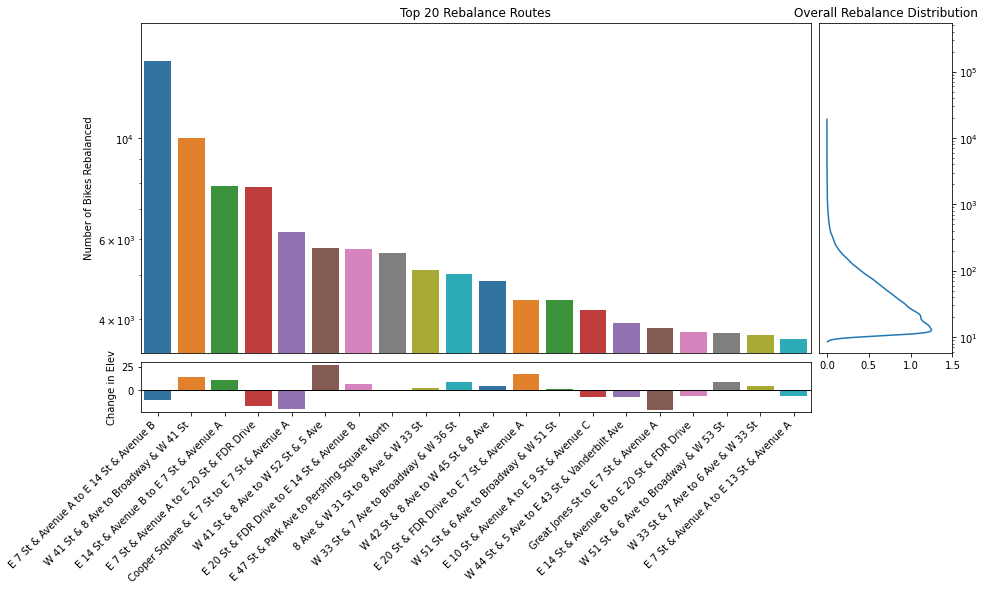

In [ ]:
# combine above with elevation data and rebal route distribution
f, axs = plt.subplots(
    2,
    2,
    figsize=(12, 6),
    gridspec_kw={"height_ratios": [1, 0.15], "width_ratios": [1, 0.2]},
)
f.tight_layout()
f.subplots_adjust(wspace=0.02, hspace=0.05)

# plot rebal routes
y = sns.barplot(
    y=rebpair.rebal_count,
    x=rebpair.rebal_route[:20],
    ax=axs[0, 0],
    palette="tab10",
)
y.set_yscale("log")
y.set(
    xticklabels=[],
    xticks=[],
    title="Top 20 Rebalance Routes",
    xlabel="",
    ylabel="Number of Bikes Rebalanced",
    ylim=(0, 18000),
)

# plot rebal elevaton changes
x = sns.barplot(
    y=rebpair.rebal_elev_change,
    x=rebpair.rebal_route[:20],
    ax=axs[1, 0],
    palette="tab10",
)
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(
    xlabel="",
    ylabel="Change in Elev",
)
axs[1, 0].axhline(0, c="black", lw=1)

# plot rebal distribution
z = sns.kdeplot(y=rebpair.rebal_count, ax=axs[0, 1], log_scale=[False, True])
z.set(
    ylim=(0, 550000),
    xlim=(-0.1, 1.5),
    title="Overall Rebalance Distribution",
    xlabel="",
    ylabel="",
)
axs[0, 1].yaxis.tick_right()


# hide last axis
axs[-1, -1].axis("off")

[Text(0.5, 51.0, ''), Text(75.875, 0.5, 'Change in Capacity')]

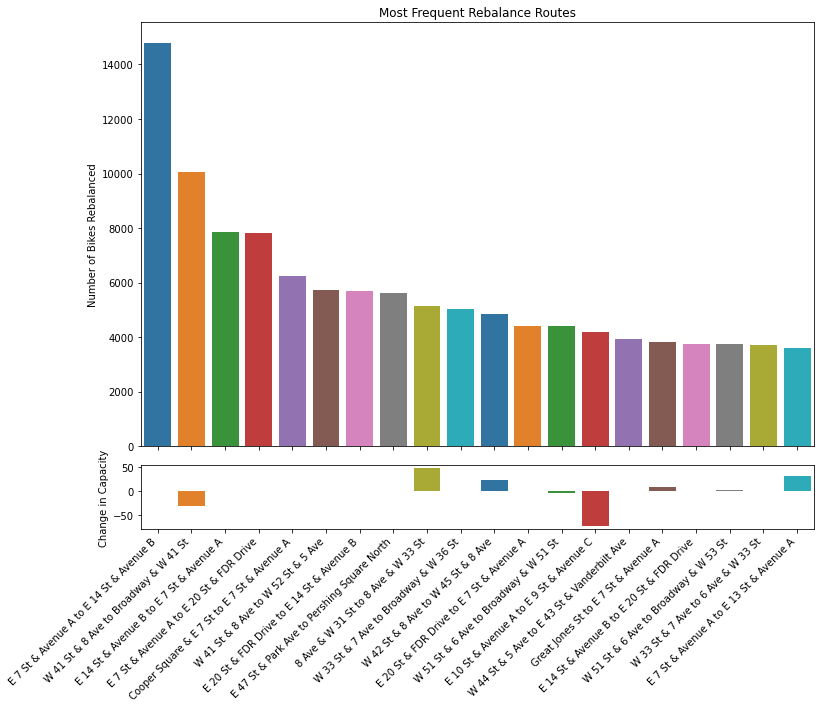

In [ ]:
# combine above with capacity data
f, axs = plt.subplots(
    2, 1, figsize=(12, 8), sharex=True, gridspec_kw={"height_ratios": [1, 0.15]}
)
y = sns.barplot(
    y=rebpair.rebal_count, x=rebpair.rebal_route[:20], ax=axs[0], palette="tab10"
)
y.set(
    title="Most Frequent Rebalance Routes",
    xlabel="",
    ylabel="Number of Bikes Rebalanced",
)
x = sns.barplot(
    y=rebpair.rebal_cap_change, x=rebpair.rebal_route[:20], ax=axs[1], palette="tab10"
)
f.tight_layout()
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(
    xlabel="",
    ylabel="Change in Capacity",
)

#### Most Frequent Rebalance Routes (two way flow)

In [ ]:
# review rebpair df
rebpair.head()

,startstationname,prevtrip_endstationname,rebal_count,rebal_elev_change,rebal_cap_change,stationid_to,stationid_from,rebal_route
0,E 14 St & Avenue B,E 7 St & Avenue A,14800,-11.0,0.0,511,432,E 7 St & Avenue A to E 14 St & Avenue B
1,Broadway & W 41 St,W 41 St & 8 Ave,10047,14.0,-32.0,465,477,W 41 St & 8 Ave to Broadway & W 41 St
2,E 7 St & Avenue A,E 14 St & Avenue B,7840,11.0,0.0,432,511,E 14 St & Avenue B to E 7 St & Avenue A
3,E 20 St & FDR Drive,E 7 St & Avenue A,7816,-17.0,NaN,487,432,E 7 St & Avenue A to E 20 St & FDR Drive
4,E 7 St & Avenue A,Cooper Square & E 7 St,6237,-20.0,NaN,432,3263,Cooper Square & E 7 St to E 7 St & Avenue A


In [ ]:
# create a copy for reversing routes
rebpair_rev = rebpair.copy(deep=True)
rebpair_rev.head()

,startstationname,prevtrip_endstationname,rebal_count,rebal_elev_change,rebal_cap_change,stationid_to,stationid_from,rebal_route
0,E 14 St & Avenue B,E 7 St & Avenue A,14800,-11.0,0.0,511,432,E 7 St & Avenue A to E 14 St & Avenue B
1,Broadway & W 41 St,W 41 St & 8 Ave,10047,14.0,-32.0,465,477,W 41 St & 8 Ave to Broadway & W 41 St
2,E 7 St & Avenue A,E 14 St & Avenue B,7840,11.0,0.0,432,511,E 14 St & Avenue B to E 7 St & Avenue A
3,E 20 St & FDR Drive,E 7 St & Avenue A,7816,-17.0,NaN,487,432,E 7 St & Avenue A to E 20 St & FDR Drive
4,E 7 St & Avenue A,Cooper Square & E 7 St,6237,-20.0,NaN,432,3263,Cooper Square & E 7 St to E 7 St & Avenue A


In [ ]:
# reverse rebal route
rebpair_rev["rebal_route"] = (
    rebpair_rev.startstationname.astype("str")
    + " to "
    + rebpair_rev.prevtrip_endstationname.astype("str")
)
rebpair_rev.head()

,startstationname,prevtrip_endstationname,rebal_count,rebal_elev_change,rebal_cap_change,stationid_to,stationid_from,rebal_route
0,E 14 St & Avenue B,E 7 St & Avenue A,14800,-11.0,0.0,511,432,E 14 St & Avenue B to E 7 St & Avenue A
1,Broadway & W 41 St,W 41 St & 8 Ave,10047,14.0,-32.0,465,477,Broadway & W 41 St to W 41 St & 8 Ave
2,E 7 St & Avenue A,E 14 St & Avenue B,7840,11.0,0.0,432,511,E 7 St & Avenue A to E 14 St & Avenue B
3,E 20 St & FDR Drive,E 7 St & Avenue A,7816,-17.0,NaN,487,432,E 20 St & FDR Drive to E 7 St & Avenue A
4,E 7 St & Avenue A,Cooper Square & E 7 St,6237,-20.0,NaN,432,3263,E 7 St & Avenue A to Cooper Square & E 7 St


In [ ]:
# concat dfs
rebpair_rev = pd.concat([rebpair_rev, rebpair], axis=0)

In [ ]:
# confirm that a given station pair has two routes
rebpair_rev.loc[rebpair_rev.rebal_route == "E 14 St & Avenue B to E 7 St & Avenue A"]

,startstationname,prevtrip_endstationname,rebal_count,rebal_elev_change,rebal_cap_change,stationid_to,stationid_from,rebal_route
0,E 14 St & Avenue B,E 7 St & Avenue A,14800,-11.0,0.0,511,432,E 14 St & Avenue B to E 7 St & Avenue A
2,E 7 St & Avenue A,E 14 St & Avenue B,7840,11.0,0.0,432,511,E 14 St & Avenue B to E 7 St & Avenue A


In [ ]:
# group by rebal route to determine total bidirecitonal flow - note that each route appears twice (once for each direction) with the same count
g = (
    rebpair_rev.groupby("rebal_route")[["rebal_count"]]
    .sum()
    .reset_index()
    .sort_values("rebal_count", ascending=False)
)
g

,rebal_route,rebal_count
62236,E 7 St & Avenue A to E 14 St & Avenue B,22640
46020,E 14 St & Avenue B to E 7 St & Avenue A,22640
62247,E 7 St & Avenue A to E 20 St & FDR Drive,12230
49428,E 20 St & FDR Drive to E 7 St & Avenue A,12230
25077,Broadway & W 41 St to W 41 St & 8 Ave,10877
...,...,...
99516,Riverside Dr & W 82 St to Plaza St West & Flat...,11
99528,Riverside Dr & W 82 St to Suffolk St & Stanton St,11
39446,Cooper Square & E 7 St to E 55 St & 2 Ave,11
39445,Cooper Square & E 7 St to E 53 St & Madison Ave,11


In [ ]:
# confirm top 20 values only have two occurances and therefore one is safe to drop (also checked through top 100)
g.value_counts("rebal_count").sort_index(ascending=False)[:20]

rebal_count
22640    2
12230    2
10877    2
9451     2
8111     2
7559     2
6070     2
5894     2
5842     2
5814     2
5721     2
5494     2
5338     2
5184     2
5158     2
5134     2
5120     2
4983     2
4799     2
4599     2
dtype: int64

In [ ]:
# drop the duplicates
g = g.drop_duplicates(subset="rebal_count")
g

,rebal_route,rebal_count
62236,E 7 St & Avenue A to E 14 St & Avenue B,22640
62247,E 7 St & Avenue A to E 20 St & FDR Drive,12230
25077,Broadway & W 41 St to W 41 St & 8 Ave,10877
49373,E 20 St & FDR Drive to E 14 St & Avenue B,9451
39451,Cooper Square & E 7 St to E 7 St & Avenue A,8111
...,...,...
91030,N 8 St & Driggs Ave to Central Park W & W 96 St,15
35614,Cleveland Pl & Spring St to Brooklyn Bridge Pa...,14
13603,Albany Ave & Fulton St to Front St & Jay St,13
126537,W 59 St & 10 Ave to Front St & Maiden Ln,12


[Text(0.5, 0, ''),
 Text(0, 0.5, 'Bikes Rebalanced'),
 Text(0.5, 1.0, 'Bi-directional Bike Rebalancing Between Station Pairs - Top 20')]

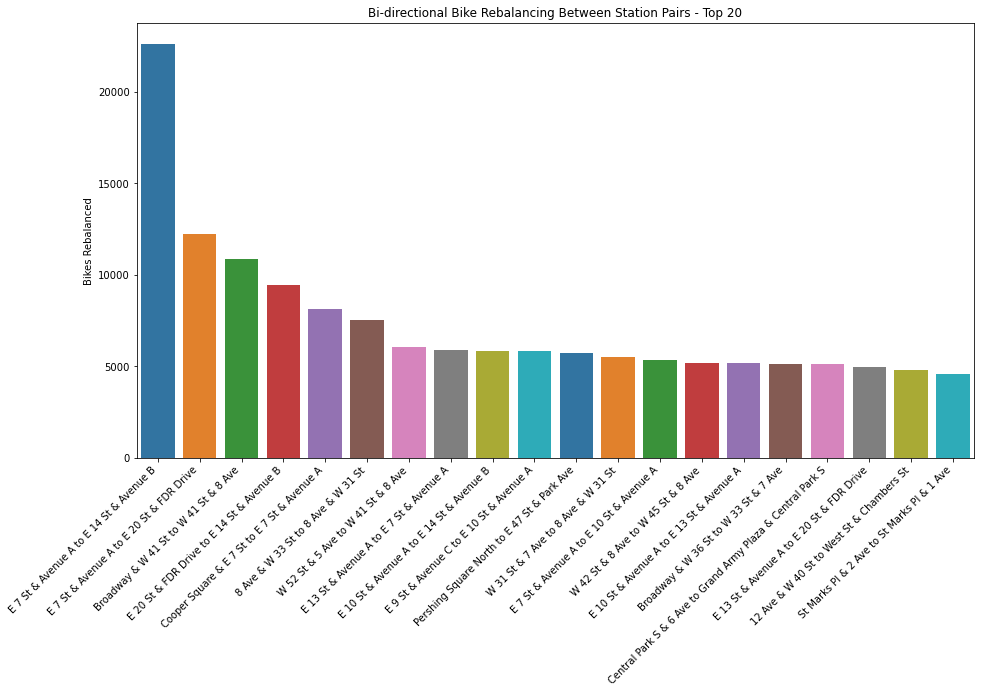

In [ ]:
plt.figure(figsize=(15, 8))
x = sns.barplot(x=g.rebal_route[:20], y=g.rebal_count, palette="tab10")
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(
    xlabel="",
    ylabel="Bikes Rebalanced",
    title="Bi-directional Bike Rebalancing Between Station Pairs - Top 20",
)

## Boro
No faceting performed, is possible if desired


### Cumulative Activity

/tmp/ipykernel_288/281795470.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_yticklabels(ylabels)


[Text(0, 0.5, 'Bikes Rebalanced'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bikes Rebalanced To Boro')]

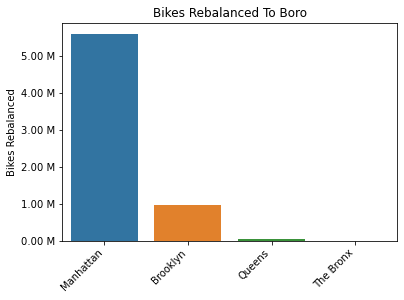

In [ ]:
# total rebalances to a boro
x = sns.countplot(data=rebal, x="startboro")
x.set_xticklabels(y.get_xticklabels(), rotation=45, horizontalalignment="right")
ylabels = ["{:,.2f}".format(y) + " M" for y in x.get_yticks() / 1000000]
x.set_yticklabels(ylabels)
x.set(ylabel="Bikes Rebalanced", xlabel="", title="Bikes Rebalanced To Boro")

### Rebalances Within and Across Boros

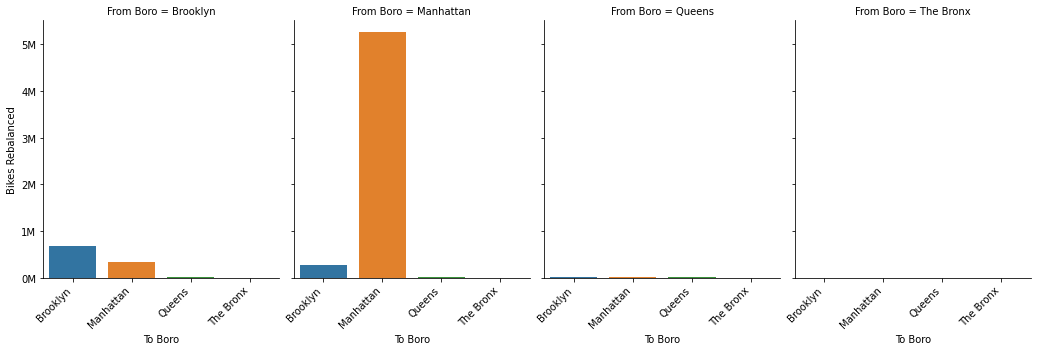

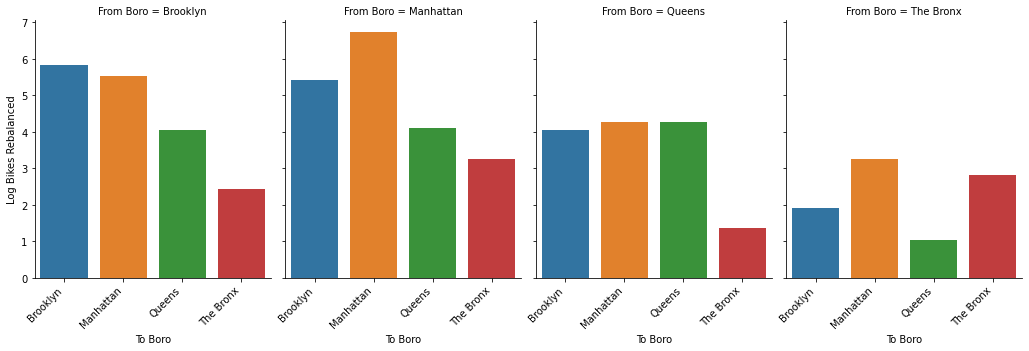

In [ ]:
g = rebal.groupby(["prevtrip_boro", "startboro"])[["bikeid"]].count().reset_index()
g.rename(columns={"prevtrip_boro": "From Boro"}, inplace=True)
g["logbikeid"] = np.log10(g.bikeid)

# plot standard scale
x = sns.catplot(
    x="startboro",
    y="bikeid",
    col="From Boro",
    data=g,
    kind="bar",
    height=4.5,
    aspect=0.8,
)
x.set_xticklabels(rotation=45, horizontalalignment="right")
x.set(ylabel="Bikes Rebalanced", xlabel="To Boro")
plt.ticklabel_format(axis="y", style="plain")

for ax in x.axes.flat:
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y/1000000:.0f}M"))


# plot log scale
x = sns.catplot(
    x="startboro",
    y="logbikeid",
    col="From Boro",
    data=g,
    kind="bar",
    height=4.5,
    aspect=0.8,
)
x.set_xticklabels(rotation=45, horizontalalignment="right")
x.set(ylabel="Log Bikes Rebalanced", xlabel="To Boro")

## Estimating Rebalance Time
- Not very accurate, this is just the window in which rebalances happen
- There are negative rebalances - this may highlight an issue with our rebalance approach!?! Do we need an additional sort when creating tables?

## Understanding the source of negative rebalance time
During this EDA, we discovered some rebalance activity appeared to have a negative duration (the start time of a new trip began before the stop time of the previous trip for a given bike). Further investigation revealed there are errors in the source data that affects primarily 2014 (7080 instances) but also other years 2015-2018. An example is provided below - notice how the trip 3626082 begins and ends while the bike is already checked out for another ride. When that row included in building the rebalance table it appears to cause two additional rebalances that were not actually present (rows 1983 and 1984) and each 'bad' trip record and further offsets all following rebalance rows. Luckily a problem with bike 14530 would not cause offsets with the next bike (method is robust such that one bike with an offset row would not affect other bikes).

It is possible to correct this issue as we build the rebalance table using the following methodology:
- build the rebalance table
- identify the first row with < 0 rebalance time
- use startime and stoptime to selectively drop the offending row from the rides table
- rebuild the rebalance table
- repeat until no rows have <0 rebalance time
	    

In [ ]:
#cause intentional syntax error to prevent the following cells from being executed accidentally from a 'run all' call
cause a syntax error

SyntaxError: invalid syntax (554484487.py, line 2)

In [ ]:
# generate 2014 rides table (pre-fix)
cause a syntax error

years = [2014]

# set import columns and preferred dtypes
trip_columns = [
    "starttime",
    "stoptime",
    "startstationid",
    "endstationid",
    "bikeid",
]
col_types = {
    "starttime": "datetime64",
    "stoptime": "datetime64",
}

# create an dummy dataframe to offset when merging
offset = pd.DataFrame(
    {
        "starttime": pd.to_datetime("2010-09-01"),
        "startstationid": 0,
        "stoptime": pd.to_datetime("2010-09-01"),
        "endstationid": 0,
        "bikeid": 0,
    },
    index=[0],
)

for year in years:

    # load data from parquet
    print("starting...", year, "----------------------")
    print("loading...")
    trips = pd.read_parquet(
        "../data/tripdata_parquet/NY/" + str(year) + ".parquet",
        engine="pyarrow",
        columns=trip_columns,
    ).reset_index()
    trips.drop(trips.columns[0], axis=1, inplace=True)  # drop the dask index

    # convert date cols to enable sorting
    print("converting date types...")
    trips = trips.astype(col_types)

    # order trips sequentially by bike and start time
    print("sorting...")
    trips = trips.sort_values(by=["bikeid", "starttime"])

    # offset rides1 (start stations) to track end station, rides 2 for start station
    print("creating trips1...")
    trips1 = (
        pd.concat([offset, trips])
        .reset_index(drop=True)
        .rename(columns={"bikeid": "bikeid1"})
    )

    print("creating trips2...")
    trips2 = (
        pd.concat([trips, offset])
        .reset_index(drop=True)
        .rename(columns={"bikeid": "bikeid2"})
    )

    # concat horizontally - a ride would start from the same endstation unless rebalanced
    print("concating trips1 and trips 2...")
    rebal = pd.concat(
        [
            trips1[["bikeid1", "stoptime", "endstationid"]],
            trips2[["bikeid2", "starttime", "startstationid"]],
        ],
        axis=1,
    )

    # remove temp dataframes from memory
    del [trips1, trips2]
    gc.collect()

    # filter using rebalance criteria
    print("filtering....")
    rebal = rebal.loc[
        (rebal.bikeid1 == rebal.bikeid2) & (rebal.startstationid != rebal.endstationid)
    ]
    rebal.drop(columns=["bikeid2"], inplace=True)

    # format
    print("formatting...")
    rebal.rename(
        columns={
            "bikeid1": "bikeid",
            "stoptime": "prevtrip_stoptime",
            "endstationid": "prevtrip_endstationid",
        },
        inplace=True,
    )

    #add rebalance time row
    rebal["rebal_time_hr"] = (rebal.starttime - rebal.prevtrip_stoptime) / np.timedelta64(
    1, "h")

    # catch bad trip records (indicates a ride was started while anothe ride with that bikeid was in progress)
    neg = rebal.loc[rebal.rebal_time_hr<0]
    
    # removes first offending record from rides table and continues looping until none are left
    # loop is required because fixing first real bad record *may or may not* fix subsequent bad records for a given bike
    if neg.shape[0] > 0:
        print('up to',neg.shape[0],'bad records found - begin drop loop...')
        count = 0
    
    while neg.shape[0] > 0:
        count +=1
        print('dropping bad record',count)
        drop_trip = neg.prevtrip_stoptime.iloc[0]
        trips = trips[trips.stoptime!= drop_trip]
        
        # offset rides1 (start stations) to track end station, rides 2 for start station
        trips1 = (
            pd.concat([offset, trips])
            .reset_index(drop=True)
            .rename(columns={"bikeid": "bikeid1"})
        )

        trips2 = (
            pd.concat([trips, offset])
            .reset_index(drop=True)
            .rename(columns={"bikeid": "bikeid2"})
        )

        # concat horizontally - a ride would start from the same endstation unless rebalanced
        rebal = pd.concat(
            [
                trips1[["bikeid1", "stoptime", "endstationid"]],
                trips2[["bikeid2", "starttime", "startstationid"]],
            ],
            axis=1,
        )

        # remove temp dataframes from memory
        del [trips1, trips2]
        gc.collect()

        # filter using rebalance criteria
        rebal = rebal.loc[
            (rebal.bikeid1 == rebal.bikeid2) & (rebal.startstationid != rebal.endstationid)
        ]
        rebal.drop(columns=["bikeid2"], inplace=True)

        # format and export
        rebal.rename(
            columns={
                "bikeid1": "bikeid",
                "stoptime": "prevtrip_stoptime",
                "endstationid": "prevtrip_endstationid",
            },
            inplace=True,
        )

        #add rebalance time row
        rebal["rebal_time_hr"] = (rebal.starttime - rebal.prevtrip_stoptime) / np.timedelta64(
        1, "h")
        
        #update negative rebalances
        neg = rebal.loc[rebal.rebal_time_hr<0]

    # export
    print("exporting to parquet...")
    rebal_filepath = "../data/rebalance_parquet/" + str(year) + "_rebalances.parquet"
    rebal.to_parquet(rebal_filepath, engine="pyarrow")

    # remove df from memory before loop
    del trips
    del rebal
    gc.collect()

print("complete!")

years = [2014]

# set import columns and preferred dtypes
trip_columns = [
    "starttime",
    "stoptime",
    "startstationid",
    "endstationid",
    "bikeid",
]
col_types = {
    "starttime": "datetime64",
    "stoptime": "datetime64",
}

# create an dummy dataframe to offset when merging
offset = pd.DataFrame(
    {
        "starttime": pd.to_datetime("2010-09-01"),
        "startstationid": 0,
        "stoptime": pd.to_datetime("2010-09-01"),
        "endstationid": 0,
        "bikeid": 0,
    },
    index=[0],
)

for year in years:

    # load data from parquet
    print("starting...", year, "----------------------")
    print("loading...")
    trips = pd.read_parquet(
        "../data/tripdata_parquet/NY/" + str(year) + ".parquet",
        engine="pyarrow",
        columns=trip_columns,
    ).reset_index()
    trips.drop(trips.columns[0], axis=1, inplace=True)  # drop the dask index

    # convert date cols to enable sorting
    print("converting date types...")
    trips = trips.astype(col_types)

    # order trips sequentially by bike and start time
    print("sorting...")
    trips = trips.sort_values(by=["bikeid", "starttime"])

    # offset rides1 (start stations) to track end station, rides 2 for start station
    print("creating trips1...")
    trips1 = (
        pd.concat([offset, trips])
        .reset_index(drop=True)
        .rename(columns={"bikeid": "bikeid1",'starttime':'starttime1','stoptime':'stoptime1'})
    )

    print("creating trips2...")
    trips2 = (
        pd.concat([trips, offset])
        .reset_index(drop=True)
        .rename(columns={"bikeid": "bikeid2",'starttime':'starttime2','stoptime':'stoptime2'})
    )


starting... 2014 ----------------------
loading...
converting date types...
sorting...
creating trips1...
creating trips2...


In [ ]:
# trip 3626082 is likely an error
cause a syntax error

trips.iloc[1981:1985]

,starttime,stoptime,startstationid,endstationid,bikeid
3624891,2014-06-08 15:09:51,2014-06-08 15:23:09,510,490,14530
3625659,2014-06-08 15:27:16,2014-06-08 16:19:23,490,523,14530
3626082,2014-06-08 15:37:17,2014-06-08 15:39:09,446,444,14530
3628199,2014-06-08 16:26:44,2014-06-08 16:55:36,523,375,14530


In [ ]:
# concat horizontally - a ride would start from the same endstation unless rebalanced
cause a syntax error

print("concating trips1 and trips 2...")
trips_combined = pd.concat(
    [
        trips1,
        trips2,
    ],
    axis=1,
)

concating trips1 and trips 2...


In [ ]:
# the trip that starts on row 1983 and ends on 1984 causes two false rebalances (one for each row)
# tre trip that starts on row 1984 started at the same station as the previous real ride - no rebalance should have occurred!
cause a syntax error
trips_combined.iloc[1983:1986]

,starttime1,startstationid,stoptime1,endstationid,bikeid1,starttime2,stoptime2,startstationid,endstationid,bikeid2
1983,2014-06-08 15:27:16,490,2014-06-08 16:19:23,523,14530,2014-06-08 15:37:17,2014-06-08 15:39:09,446,444,14530
1984,2014-06-08 15:37:17,446,2014-06-08 15:39:09,444,14530,2014-06-08 16:26:44,2014-06-08 16:55:36,523,375,14530
1985,2014-06-08 16:26:44,523,2014-06-08 16:55:36,375,14530,2014-06-08 17:45:03,2014-06-08 18:06:03,2010,237,14530


In [ ]:
# all 2014 bad rebalance rows
cause a syntax error
wtf = rebal.loc[(rebal.rebal_time_hr < 0)&(rebal.rebal_year==2014)]
wtf

,bikeid,prevtrip_stoptime,prevtrip_endstationid,starttime,startstationid,startstationname,startcapacity,startneighborhood,startboro,startelevation_ft,prevtrip_endstationname,prevtrip_capacity,prevtrip_neighborhood,prevtrip_boro,prevtrip_elevation_ft,rebal_dow,rebal_dom,rebal_week,rebal_month,rebal_year,rebal_time_hr,rebal_elev_change,startelevation_bin,prevtrip_elevation_bin
239,14530,2014-06-08 16:19:23,523,2014-06-08 15:37:17,446,W 24 St & 7 Ave,79.0,Chelsea District,Manhattan,28.671875,W 38 St & 8 Ave,NaN,Garment District,Manhattan,37.281250,6,8,23,6,2014,-0.701667,-8.609375,"(25, 50]","(25, 50]"
654,14532,2014-10-08 21:14:46,518,2014-10-08 21:05:42,505,6 Ave & W 33 St,52.0,Manhattan Community Board 5,Manhattan,43.187500,E 39 St & 2 Ave,52.0,Murray Hill,Manhattan,30.843750,2,8,41,10,2014,-0.151111,12.343750,"(25, 50]","(25, 50]"
655,14532,2014-10-09 03:48:31,492,2014-10-08 23:07:21,518,E 39 St & 2 Ave,52.0,Murray Hill,Manhattan,30.843750,W 33 St & 7 Ave,NaN,Chelsea District,Manhattan,39.218750,2,8,41,10,2014,-4.686111,-8.375000,"(25, 50]","(25, 50]"
801,14533,2014-08-19 19:25:07,515,2014-08-19 19:02:43,472,E 32 St & Park Ave,55.0,Midtown South,Manhattan,45.093750,W 43 St & 10 Ave,79.0,Manhattan Community Board 4,Manhattan,25.531250,1,19,34,8,2014,-0.373333,19.562500,"(25, 50]","(25, 50]"
811,14533,2014-08-26 12:21:22,530,2014-08-26 12:02:33,496,E 16 St & 5 Ave,65.0,Union Square,Manhattan,38.187500,11 Ave & W 59 St,24.0,Manhattan Community Board 4,Manhattan,18.718750,1,26,35,8,2014,-0.313611,19.468750,"(25, 50]","(0, 25]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120488,21683,2014-10-24 18:40:29,250,2014-10-24 18:12:10,500,Broadway & W 51 St,52.0,Theater District,Manhattan,62.218750,Lafayette St & Jersey St,40.0,Manhattan Community Board 2,Manhattan,40.843750,4,24,43,10,2014,-0.471944,21.375000,"(50, 75]","(25, 50]"
1120750,21689,2014-09-17 18:29:19,137,2014-09-17 18:10:50,505,6 Ave & W 33 St,52.0,Manhattan Community Board 5,Manhattan,43.187500,E 56 St & Madison Ave,23.0,Manhattan Community Board 5,Manhattan,51.531250,2,17,38,9,2014,-0.308056,-8.343750,"(25, 50]","(50, 75]"
1120751,21689,2014-09-17 22:09:09,511,2014-09-17 18:32:55,137,E 56 St & Madison Ave,23.0,Manhattan Community Board 5,Manhattan,51.531250,E 14 St & Avenue B,31.0,Manhattan Community Board 6,Manhattan,9.953125,2,17,38,9,2014,-3.603889,41.562500,"(50, 75]","(0, 25]"
1120867,21690,2014-10-14 19:48:38,511,2014-10-14 19:39:38,439,E 4 St & 2 Ave,43.0,East Village,Manhattan,37.593750,E 14 St & Avenue B,31.0,Manhattan Community Board 6,Manhattan,9.953125,1,14,42,10,2014,-0.150000,27.640625,"(25, 50]","(0, 25]"


In [ ]:
# number of bikes with at least one bad record
cause a syntax error
wtf.bikeid.nunique()

3251

In [ ]:
# number of unique bike ids in 2014
cause a syntax error
trips.bikeid.nunique()

6811

In [ ]:
# number of negative time rebalance counts per year
cause a syntax error
rebal.loc[rebal.rebal_time_hr<0].rebal_year.value_counts()

2014    7080
2015     226
2016      13
2017       6
2018       1
Name: rebal_year, dtype: int64

It is OK to run the following cells

In [ ]:
# run the following cells for example of how the fix was implemented

years = [2017]

# set import columns and preferred dtypes
trip_columns = [
    "starttime",
    "stoptime",
    "startstationid",
    "endstationid",
    "bikeid",
]
col_types = {
    "starttime": "datetime64",
    "stoptime": "datetime64",
}

# create an dummy dataframe to offset when merging
offset = pd.DataFrame(
    {
        "starttime": pd.to_datetime("2010-09-01"),
        "startstationid": 0,
        "stoptime": pd.to_datetime("2010-09-01"),
        "endstationid": 0,
        "bikeid": 0,
    },
    index=[0],
)

for year in years:

    # load data from parquet
    print("starting...", year, "----------------------")
    print("loading...")
    trips = pd.read_parquet(
        "../data/tripdata_parquet/NY/" + str(year) + ".parquet",
        engine="pyarrow",
        columns=trip_columns,
    ).reset_index()
    trips.drop(trips.columns[0], axis=1, inplace=True)  # drop the dask index

    # convert date cols to enable sorting
    print("converting date types...")
    trips = trips.astype(col_types)

    # order trips sequentially by bike and start time
    print("sorting...")
    trips = trips.sort_values(by=["bikeid", "starttime"])

    # offset rides1 (start stations) to track end station, rides 2 for start station
    print("creating trips1...")
    trips1 = (
        pd.concat([offset, trips])
        .reset_index(drop=True)
        .rename(columns={"bikeid": "bikeid1"})
    )

    print("creating trips2...")
    trips2 = (
        pd.concat([trips, offset])
        .reset_index(drop=True)
        .rename(columns={"bikeid": "bikeid2"})
    )

    # concat horizontally - a ride would start from the same endstation unless rebalanced
    print("concating trips1 and trips 2...")
    rebal = pd.concat(
        [
            trips1[["bikeid1", "stoptime", "endstationid"]],
            trips2[["bikeid2", "starttime", "startstationid"]],
        ],
        axis=1,
    )

    # remove temp dataframes from memory
    del [trips1, trips2]
    gc.collect()

    # filter using rebalance criteria
    print("filtering....")
    rebal = rebal.loc[
        (rebal.bikeid1 == rebal.bikeid2) & (rebal.startstationid != rebal.endstationid)
    ]
    rebal.drop(columns=["bikeid2"], inplace=True)

    # format
    print("formatting...")
    rebal.rename(
        columns={
            "bikeid1": "bikeid",
            "stoptime": "prevtrip_stoptime",
            "endstationid": "prevtrip_endstationid",
        },
        inplace=True,
    )

    # add rebalance time row
    rebal["rebal_time_hr"] = (
        rebal.starttime - rebal.prevtrip_stoptime
    ) / np.timedelta64(1, "h")

    # catch bad trip records (indicates a ride was started while anothe ride with that bikeid was in progress)
    neg = rebal.loc[rebal.rebal_time_hr < 0]

    # removes first offending record from rides table and continues looping until none are left
    # loop is required because fixing first real bad record *may or may not* fix subsequent bad records for a given bike
    if neg.shape[0] > 0:
        print("up to", neg.shape[0], "bad records found - begin drop loop...")
        count = 0

    while neg.shape[0] > 0:
        count += 1
        print("dropping bad record", count)
        drop_trip = neg.prevtrip_stoptime.iloc[0]
        trips = trips[trips.stoptime != drop_trip]

        # offset rides1 (start stations) to track end station, rides 2 for start station
        trips1 = (
            pd.concat([offset, trips])
            .reset_index(drop=True)
            .rename(columns={"bikeid": "bikeid1"})
        )

        trips2 = (
            pd.concat([trips, offset])
            .reset_index(drop=True)
            .rename(columns={"bikeid": "bikeid2"})
        )

        # concat horizontally - a ride would start from the same endstation unless rebalanced
        rebal = pd.concat(
            [
                trips1[["bikeid1", "stoptime", "endstationid"]],
                trips2[["bikeid2", "starttime", "startstationid"]],
            ],
            axis=1,
        )

        # remove temp dataframes from memory
        del [trips1, trips2]
        gc.collect()

        # filter using rebalance criteria
        rebal = rebal.loc[
            (rebal.bikeid1 == rebal.bikeid2)
            & (rebal.startstationid != rebal.endstationid)
        ]
        rebal.drop(columns=["bikeid2"], inplace=True)

        # format and export
        rebal.rename(
            columns={
                "bikeid1": "bikeid",
                "stoptime": "prevtrip_stoptime",
                "endstationid": "prevtrip_endstationid",
            },
            inplace=True,
        )

        # add rebalance time row
        rebal["rebal_time_hr"] = (
            rebal.starttime - rebal.prevtrip_stoptime
        ) / np.timedelta64(1, "h")

        # update negative rebalances
        neg = rebal.loc[rebal.rebal_time_hr < 0]

    # export
    print("exporting to parquet...")
    rebal_filepath = "../data/rebalance_parquet/" + str(year) + "_rebalances.parquet"
    rebal.to_parquet(rebal_filepath, engine="pyarrow")

    # remove df from memory before loop
    del trips
    del rebal
    gc.collect()

print("complete!")

starting... 2017 ----------------------
loading...
converting date types...
sorting...
creating trips1...
creating trips2...
concating trips1 and trips 2...
filtering....
formatting...
up to 6 bad records found - begin drop loop...
dropping bad record 1
dropping bad record 2
dropping bad record 3
dropping bad record 4
dropping bad record 5
dropping bad record 6
exporting to parquet...
complete!


In [ ]:
test = pd.read_parquet("../data/rebalance_parquet/2017_rebalances.parquet")
test.head()

,bikeid,prevtrip_stoptime,prevtrip_endstationid,starttime,startstationid,rebal_time_hr
2,14529,2017-01-01 13:50:25,319,2017-01-02 13:44:50,225,23.906944
14,14529,2017-01-06 06:44:24,335,2017-01-06 09:56:37,432,3.203611
15,14529,2017-01-06 09:59:57,3263,2017-01-06 11:35:49,432,1.597778
49,14529,2017-01-13 18:19:23,167,2017-01-16 07:48:44,477,61.489167
57,14529,2017-01-17 07:16:30,324,2017-01-21 13:11:38,354,101.918889


In [ ]:
test.loc[test.rebal_time_hr < 0]

,bikeid,prevtrip_stoptime,prevtrip_endstationid,starttime,startstationid,rebal_time_hr
